In [1]:
# Робота з таблицями та даними
import pandas as pd
import numpy as np

# Візуалізації
import matplotlib.pyplot as plt
import seaborn as sns

# Статистика
from scipy import stats

# Google BigQuery
from google.cloud import bigquery
from google.colab import auth

In [2]:
auth.authenticate_user()


**Джерело даних**:

Дані зберігаються в Google BigQuery (навчальний dataset DA).

**Отримання даних:**

Для формування аналітичного датасету використано SQL-запит з обʼєднанням кількох таблиць (sessions, orders, products, accounts). Запит виконується безпосередньо з Python за допомогою BigQuery client, результат завантажується у pandas DataFrame.

**Обґрунтування підходу:**

Такий підхід дозволяє автоматизувати процес отримання даних (ETL), уникнути ручного експорту та забезпечує відтворюваність аналізу. Створення view або таблиць у BigQuery обмежене правами доступу в навчальному проєкті.


In [3]:
client = bigquery.Client(project="data-analytics-mate")


In [4]:
query = """
SELECT
    s.date,
    s.ga_session_id,
    sp.continent,
    sp.country,
    sp.device,
    sp.browser,
    sp.mobile_model_name,
    sp.operating_system,
    sp.language,
    sp.name AS traffic_source,
    sp.channel,
    sp.medium,
    acs.account_id,
    ac.is_verified,
    ac.is_unsubscribed,
    p.name AS product_name,
    p.category,
    p.price,
    p.short_description
FROM `DA.session` AS s
LEFT JOIN `DA.session_params` AS sp
    ON sp.ga_session_id = s.ga_session_id
LEFT JOIN `DA.account_session` AS acs
    ON acs.ga_session_id = s.ga_session_id
LEFT JOIN `DA.account` AS ac
    ON ac.id = acs.account_id
LEFT JOIN `DA.order` AS o
    ON o.ga_session_id = s.ga_session_id
LEFT JOIN `DA.product` AS p
    ON p.item_id = o.item_id
"""


In [5]:
df = client.query(query).to_dataframe()
print(df)


              date  ga_session_id continent        country   device  \
0       2020-11-01      967742695  Americas  United States  desktop   
1       2020-11-01     9065007548      Asia          China  desktop   
2       2020-11-01     3267062634  Americas  United States  desktop   
3       2020-11-01     8892952409  Americas  United States   mobile   
4       2020-11-01     1624570787      Asia         Turkey  desktop   
...            ...            ...       ...            ...      ...   
349540  2021-01-31      830102441  Americas  United States  desktop   
349541  2021-01-31      167350204    Europe         Poland   mobile   
349542  2021-01-31     1587098569  Americas  United States   mobile   
349543  2021-01-31     5756982967    Europe        Ukraine  desktop   
349544  2021-01-31     7058940865    Europe         Norway  desktop   

                browser mobile_model_name operating_system language  \
0                Safari            Safari              Web    en-us   
1    

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   traffic_source     349545 non-null  object 
 10  channel            349545 non-null  object 
 11  medium             349545 non-null  object 
 12  account_id         27945 non-null   Int64  
 13  is_verified        27945 non-null   Int64  
 14  is_unsubscribed    27945 non-null   Int64  
 15  product_name       33538 non-null   object 
 16  ca

#Опис датасету
Отриманий датасет містить 349 545 рядків та 19 колонок.
Дані включають 1 колонку date,яка має специфічний тип dbdate, 5 числових колонок: Int64 (цілі числа): ga_session_id, account_id, is_verified, is_unsubscribed та float64 (числа з плаваючою точкою): price і 13 категоріальних колонок, що описують географію, девайси, джерела трафіку та товари object: continent, country, device, browser, mobile_model_name, operating_system, language, traffic_source, channel, medium, product_name, category, short_description.

Пропущені значення присутні у колонках, повʼязаних із акаунтами користувачів та товарами, що є очікуваним, оскільки не всі користувачі реєструються на сайті, а не кожна сесія завершується покупкою.

In [7]:
df.isna().sum()

,0
date,0
ga_session_id,0
continent,0
country,0
device,0
browser,0
mobile_model_name,0
operating_system,0
language,114266
traffic_source,0


In [8]:
(df.isna().mean() * 100).round(2).sort_values(ascending=False)


,0
account_id,92.01
is_unsubscribed,92.01
is_verified,92.01
category,90.41
short_description,90.41
price,90.41
product_name,90.41
language,32.69
continent,0.00
date,0.00


#**Перевірка якості даних**

##1.Робота з форматами

In [9]:
# Конвертуємо дату
df['date'] = pd.to_datetime(df['date'])

In [10]:
is_datetime = pd.api.types.is_datetime64_any_dtype(df['date'])
print(f"Чи є колонка форматом datetime? {is_datetime}")

Чи є колонка форматом datetime? True


In [11]:
# 1. Визначаємо період (від... до...)
min_date = df['date'].min()
max_date = df['date'].max()

# 2. Розраховуємо тривалість періоду в днях
delta = max_date - min_date

# Рахуємо унікальні сесії
unique_sessions = df['ga_session_id'].nunique()

print(f"Період розглядається від: {min_date.date()}")
print(f"Період розглядається до: {max_date.date()}")
print(f"Загальна тривалість: {delta.days} днів")
print(f"Кількість унікальних сесій: {unique_sessions}")

Період розглядається від: 2020-11-01
Період розглядається до: 2021-01-31
Загальна тривалість: 91 днів
Кількість унікальних сесій: 349545


In [12]:
#Перетворюємо прапорці (0/1) у числовий формат.
#Заповнюємо NaN нулями для тих, хто не підписаний/не верифікований
df['is_verified'] = df['is_verified'].fillna(0).astype(int)
df['is_unsubscribed'] = df['is_unsubscribed'].fillna(0).astype(int)

##2.Обробка пропущених значень (NaN)

**Категоріальні дані (Трафік та Гео):**

In [13]:
# Заповнюємо мову та інші текстові поля
cols_to_fix = ['language', 'traffic_source', 'channel', 'medium']
for col in cols_to_fix:
    df[col] = df[col].fillna('Not Specified')

**Дані про товари та акаунти:**

In [14]:
# Товари
df['product_name'] = df['product_name'].fillna('No Purchase')
df['category'] = df['category'].fillna('No Purchase')

# Ціна (важливо для розрахунків!)
# Замінюємо NaN на 0.0, щоб сумувати дохід
df['price'] = df['price'].fillna(0.0)

# Акаунти
df['account_id'] = df['account_id'].fillna(0) # 0 буде позначати гостя

In [15]:
print(df['price'].describe())

count    349545.000000
mean         91.466710
std         495.222334
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        9585.000000
Name: price, dtype: float64


##3.Перевірка на дублікати та порожні значення

In [16]:
duplicate_count = df.duplicated().sum()
print(f"Знайдено дублікатів: {duplicate_count}")

if duplicate_count > 0:
    df = df.drop_duplicates()
    print("Дублікати видалено.")

Знайдено дублікатів: 0


In [17]:
#Робимо перевірку на порожні значення
df.isna().sum()

,0
date,0
ga_session_id,0
continent,0
country,0
device,0
browser,0
mobile_model_name,0
operating_system,0
language,0
traffic_source,0


##4.Створення нових ознак

In [18]:
# Створюємо колонку: зареєстрований користувач чи ні
df['user_type'] = df['account_id'].apply(lambda x: 'Registered' if x > 0 else 'Guest')

# Створюємо колонку: чи була покупка в цій сесії
df['is_order'] = df['price'].apply(lambda x: 1 if x > 0 else 0)

##5.Уніфікація та стандартизація категоріальних значень

In [19]:
# Вибираємо лише текстові колонки (object)
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    print(f"--- Колонку {col} перевірено ---")
    print(df[col].unique()[:20]) # виводимо перші 20 значень, щоб не захаращувати екран
    print("\n")

--- Колонку continent перевірено ---
['Americas' 'Asia' 'Europe' 'Africa' '(not set)' 'Oceania']


--- Колонку country перевірено ---
['United States' 'China' 'Turkey' 'Spain' 'Brazil' 'Taiwan' 'Uruguay'
 'France' 'Ireland' 'Germany' 'Japan' 'United Kingdom' 'Belgium' 'India'
 'Egypt' 'Vietnam' 'Mexico' 'Canada' '(not set)' 'South Korea']


--- Колонку device перевірено ---
['desktop' 'mobile' 'tablet']


--- Колонку browser перевірено ---
['Safari' 'Chrome' 'Android Webview' '<Other>' 'Edge' 'Firefox']


--- Колонку mobile_model_name перевірено ---
['Safari' '<Other>' 'ChromeBook' 'iPhone' 'Chrome' 'Firefox' 'iPad' 'Edge'
 'Pixel 3' 'Pixel 4 XL']


--- Колонку operating_system перевірено ---
['Web' '<Other>' 'Macintosh' 'iOS' 'Windows' 'Android']


--- Колонку language перевірено ---
['en-us' 'Not Specified' 'ko' 'zh' 'en-gb' 'es-es' 'en' 'en-ca' 'fr' 'de']


--- Колонку traffic_source перевірено ---
['(data deleted)' '<Other>' '(direct)' '(organic)' '(referral)']


--- Колонку channe

In [20]:
# Визначаємо перелік технічних міток для об'єднання
technical_nulls = ['(not set)', 'Undefined', '(data deleted)', '<Other>']

# Виконуємо масову заміну для всього датафрейму
df = df.replace(technical_nulls, 'Not Specified')

# Уточнюємо назву для прямого трафіку
df = df.replace('(none)', 'None/Direct')

# Видаляємо пробіли в текстових колонках для уникнення дублів "Category" та " Category"
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()

print("Уніфікацію значень завершено успішно.")

Уніфікацію значень завершено успішно.


##Звіт:
##Очистка та підготовка даних
У цьому розділі було проведено трансформацію типів даних та обробку пропущених значень для забезпечення точності подальшого статистичного аналізу.

1. **Загальний огляд та часові межі дослідження**

Колонку date переведено з формату dbdate (об'єкт) у стандартний datetime64. Це критично важливо для аналізу динаміки продажів, виявлення сезонності та коректної візуалізації часових рядів у Python та Tableau.
Аналіз охоплює період від 2020-11-01 00:00:00 до 2021-01-31 00:00:00. Це дозволяє оцінити динаміку продажів протягом 91 дня та врахувати можливу сезонність у попиті на товари.
Загальна кількість унікальних сесій у досліджуваному датасеті становить 349 545.

2. **Обробка бінарних ознак** (is_verified, is_unsubscribed)

Колонки is_verified та is_unsubscribed спочатку мали тип Int64 та містили значну кількість пропусків (NaN).

 Оскільки дані походять із системи реєстрації, відсутність запису (NaN) фактично означає, що подія не відбулася (користувач не підтвердив email або не відписався). Тому всі NaN було замінено на 0.

 Після заповнення пропусків дані були приведені до стандартного цілочисельного типу int. Це дозволяє:


*   Проводити математичні операції (наприклад, розрахунок середнього для отримання % конверсії).
*   Забезпечити сумісність із бібліотеками для статистичних тестів та кореляційного аналізу.

*   Оптимізувати використання пам'яті.

3. **Обробка структурних пропусків**

Для колонок географії та трафіку (language, traffic_source тощо) пропуски замінено на значення "Not Specified". Це дозволяє включити ці сесії в аналіз, не втрачаючи загальний обсяг даних.

Для даних про замовлення та товари пропуски залишено або замінено на "No Purchase"/0.0 (для цін), що відображає реальний стан речей: сесія відбулася, але замовлення не було створено.

Додатково проведено перевірку на наявність повних дублікатів рядків та аномальних значень у цінах. Від'ємних значень або повторюваних записів виявлено не було, що підтверджує технічну чистоту та цілісність датасету.

4. **Створення нових показників**

Для розширення аналітичних можливостей та спрощення сегментації аудиторії до датасету було додано два нові розрахункові показники:

user_type: Категоризація користувачів на "Registered" (зареєстровані) та "Guest" (гості). Це дозволяє порівнювати поведінку лояльних клієнтів та анонімних відвідувачів.

is_order: Бінарна метрика (0 або 1), що вказує, чи було здійснено покупку під час конкретної сесії. Ця колонка є критично важливою для розрахунку коефіцієнта конверсії (CR) та проведення статистичних тестів на відмінність між групами.

5.**Уніфікація та стандартизація категоріальних значень**

Для підвищення якості візуалізацій та точності статистичних розрахунків була проведена обробка текстових міток, характерних для систем веб-аналітики (Google Analytics).

 - Консолідація технічних пропусків
Різноманітні технічні мітки, що позначають відсутність даних або помилки ідентифікації, були об’єднані в єдину категорію Not Specified.

Значення, що підлягали заміні: (not set), Undefined, (data deleted), <Other>.

 Розпорошення цих значень створює зайвий "шум" на графіках. Об'єднання дозволяє побачити загальну частку неідентифікованого трафіку як єдиний сегмент, що полегшує порівняння з основними каналами.

 - Робота зі значенням (none)
Значення (none) було перейменовано на None/Direct.

 У веб-аналітиці (none) зазвичай вказує на прямий трафік (Direct), коли користувач ввів URL вручну або перейшов із закладок. Це не є технічною помилкою, тому цю категорію було збережено окремо від Not Specified для аналізу органічного приросту аудиторії.

 - Очистка текстових артефактів
До всіх текстових колонок застосовано метод str.strip() для видалення випадкових пробілів на початку або в кінці рядків, що запобігає дублюванню категорій при групуванні.

#**`Аналіз бізнес-показників та результативності`**

##1.Географічний аналіз (Топ-3 континентів та Топ-5 країн)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               349545 non-null  datetime64[ns]
 1   ga_session_id      349545 non-null  Int64         
 2   continent          349545 non-null  object        
 3   country            349545 non-null  object        
 4   device             349545 non-null  object        
 5   browser            349545 non-null  object        
 6   mobile_model_name  349545 non-null  object        
 7   operating_system   349545 non-null  object        
 8   language           349545 non-null  object        
 9   traffic_source     349545 non-null  object        
 10  channel            349545 non-null  object        
 11  medium             349545 non-null  object        
 12  account_id         349545 non-null  Int64         
 13  is_verified        349545 non-null  int64   

In [22]:
# Рахуємо статистику по континентах (Топ-3)
top_continents = df[df['is_order'] == 1].groupby('continent')['price'].agg(['sum', 'count'])
top_continents = top_continents.sort_values(by='sum', ascending=False).head(3)
top_continents.columns = ['Total Revenue', 'Order Count']

# Рахуємо статистику по країнах (Топ-5) — додаємо кількість замовлень
top_countries_full = df[df['is_order'] == 1].groupby('country')['price'].agg(['sum', 'count'])
top_countries_full = top_countries_full.sort_values(by='sum', ascending=False).head(5)
top_countries_full.columns = ['Total Revenue', 'Order Count']

print("--- ТОП-3 КОНТИНЕНТИ ---")
print(top_continents)
print("\n--- ТОП-5 КРАЇН ---")
print(top_countries_full)

--- ТОП-3 КОНТИНЕНТИ ---
           Total Revenue  Order Count
continent                            
Americas      17665280.0        18553
Asia           7601298.3         7950
Europe         5934624.2         6261

--- ТОП-5 КРАЇН ---
                Total Revenue  Order Count
country                                   
United States      13943553.9        14673
India               2809762.0         3029
Canada              2437921.0         2560
United Kingdom       938317.9         1029
France               710692.8          678


##Висновки щодо географічного розподілу продажів:
Домінування американського континенту: Регіон Americas є абсолютним лідером, генеруючи понад $17.6 млн виручки. Це більше, ніж дохід від Азії та Європи разом узятих, що підкреслює критичну важливість західного ринку для бізнесу.

США як ключовий драйвер: United States займає перше місце серед усіх країн з виручкою $13.9 млн. Це становить близько 79% від усього доходу континенту Americas та майже 45% від загальносвітових продажів у нашому датасеті.

Потенціал азійського ринку: Asia посідає друге місце ($7.6 млн), де головним гравцем є India. Попри суттєвий відрив від США, Індія впевнено займає другу позицію у світовому рейтингу за кількістю замовлень (3 029).

Європейський сегмент: Europe замикає трійку лідерів. Хоча Велика Британія та Франція входять до ТОП-5 країн, їхні сукупні показники значно поступаються північноамериканському ринку.

Кореляція замовлень та виручки: Спостерігається пряма залежність між кількістю замовлень та доходом у всіх регіонах. Це свідчить про те, що середній чек у США, Індії та Канаді є відносно стабільним, і зростання виручки відбувається переважно за рахунок масштабування кількості клієнтів.

##2.Аналіз сегментації користувачів та категорій товарів

In [23]:
df['user_type'].unique()

array(['Guest', 'Registered'], dtype=object)

In [24]:
#Рахуємо статистику по типу користувачів
user_type_agg = df[df['is_order'] == 1].groupby('user_type')['price'].agg(['sum', 'count'])
user_type_agg.columns = ['Total Revenue', 'Order Count']
print(user_type_agg)

            Total Revenue  Order Count
user_type                             
Guest          29389212.6        30757
Registered      2582518.5         2781


In [25]:
#Рахуємо статистику по категоріях(Топ-10)
category_top = df[df['is_order'] == 1].groupby('category')['price'].agg(['sum', 'count']).sort_values(by='sum', ascending=False).head(10)
category_top.columns =  ['Total Revenue', 'Order Count']
print(category_top)

                                  Total Revenue  Order Count
category                                                    
Sofas & armchairs                     8388254.5         4301
Chairs                                6147748.8         5952
Beds                                  4919725.0         2926
Bookcases & shelving units            3640818.1         7630
Cabinets & cupboards                  2336499.5         2318
Outdoor furniture                     2142222.2         2229
Tables & desks                        1790307.5         2941
Chests of drawers & drawer units       906562.5         1452
Bar furniture                          735503.0         1092
Children's furniture                   467697.0         1702


In [26]:
#Рахуємо статистику по категоріях (Топ-10) в USA
category_top_usa = df[(df['is_order'] == 1) & (df['country'] == 'United States')].groupby('category')['price'].agg(['sum', 'count']).sort_values(by='sum', ascending=False).head(10)
category_top_usa.columns =  ['Total Revenue', 'Order Count']
print(category_top_usa)

                                  Total Revenue  Order Count
category                                                    
Sofas & armchairs                     3707144.5         1903
Chairs                                2619773.8         2576
Beds                                  2213058.0         1298
Bookcases & shelving units            1567606.9         3374
Cabinets & cupboards                   994545.5          995
Outdoor furniture                      929245.2          984
Tables & desks                         777865.0         1248
Chests of drawers & drawer units       382388.0          616
Bar furniture                          330805.0          487
Children's furniture                   207575.0          752



##Висновки щодо асортименту та поведінки покупців:
Домінування незареєстрованих користувачів: Понад 91% загальної виручки ($29.4 млн) припадає на сегмент Guest. Це вказує на те, що клієнти віддають перевагу швидкості замовлення, а обов'язкова реєстрація не є бар'єром для покупки.

Трійка лідерів за виручкою: Найбільший дохід приносять категорії меблів: Sofas & armchairs ($8.4 млн), Chairs ($6.1 млн) та Beds ($4.9 млн). Ці категорії є "фундаментом" продажів компанії.

Аналіз "ціна-обсяг":

Категорія Sofas & armchairs є найбільш прибутковою при відносно невеликій кількості замовлень (4 301), що свідчить про високий середній чек.

Категорія Bookcases & shelving units є абсолютним лідером за популярністю серед покупців (7 630 замовлень), хоча вона посідає лише 4-те місце за виручкою. Це свідчить про масовий попит на доступні рішення для зберігання.

Категорія Children's furniture замикає ТОП-10 за виручкою, маючи значну кількість замовлень (1 702), але найнижчий дохід серед лідерів ($0.46 млн), що вказує на найменшу середню вартість товарів у цій групі.

Аналіз ТОП-10 категорій у США(країна з найбільшими продажами) показав повну відповідність глобальним трендам. Перша трійка лідерів (Дивани, Стільці, Ліжка) збігається із загальносвітовою. США генерують майже половину світової виручки в ключових меблевих категоріях, що підтверджує статус цієї країни як стратегічного ринку.

## 3.Аналіз джерел трафіку та каналів залучення

In [27]:
# 1. Рахуємо загальну виручку
total_revenue = df[df['is_order'] == 1]['price'].sum()

# 2. Групуємо за типом девайса
device_analysis = df[df['is_order'] == 1].groupby('device')['price'].agg(['sum', 'count'])

# 3. Додаємо колонку з відсотками
device_analysis['percentage'] = (device_analysis['sum'] / total_revenue) * 100

# 4. Сортуємо та виводимо
device_analysis = device_analysis.sort_values(by='sum', ascending=False)
print(device_analysis)

                sum  count  percentage
device                                
desktop  18864039.0  19702   59.002245
mobile   12384225.8  13113   38.734924
tablet     723466.3    723    2.262831


In [28]:
df['mobile_model_name'].unique()

array(['Safari', 'Not Specified', 'ChromeBook', 'iPhone', 'Chrome',
       'Firefox', 'iPad', 'Edge', 'Pixel 3', 'Pixel 4 XL'], dtype=object)

In [29]:
# 1. Рахуємо ТОП-10 моделей (фільтруємо 'Not Specified')
mobile_model_top = df[(df['is_order'] == 1) & (df['mobile_model_name'] != 'Not Specified')].groupby('mobile_model_name')['price'].agg(['sum', 'count'])

# 2. Додаємо відсоток від загальної виручки
mobile_model_top['percentage'] = (mobile_model_top['sum'] / total_revenue) * 100

# 3. Сортуємо
mobile_model_top = mobile_model_top.sort_values(by='sum', ascending=False).head(10)

print(mobile_model_top)

                         sum  count  percentage
mobile_model_name                              
Chrome             8899523.9   9359   27.835602
Safari             6491062.1   6833   20.302504
iPhone             6420776.3   6819   20.082667
ChromeBook         1830458.7   1877    5.725241
Edge                697222.3    741    2.180746
iPad                448854.2    456    1.403910
Firefox             421066.9    430    1.316998
Pixel 4 XL          118287.7    117    0.369976
Pixel 3             109148.2    105    0.341390


In [30]:
# Дивимося на унікальні пари: модель + браузер для перших 10 рядків, де був заказ
check_overlap = df[df['is_order'] == 1][['mobile_model_name', 'browser']].drop_duplicates().head(10)
print(check_overlap)

    mobile_model_name          browser
0              Safari           Safari
1              Safari           Chrome
26      Not Specified           Chrome
34         ChromeBook           Chrome
36             Chrome           Chrome
87             iPhone           Safari
230     Not Specified          Firefox
257              Edge             Edge
552              iPad           Safari
562     Not Specified  Android Webview


In [31]:
# Рахуємо, скільки разів модель і браузер ідентичні
same_values = df[df['mobile_model_name'] == df['browser']].shape[0]
total_rows = df.shape[0]

print(f"Кількість рядків, де модель = браузер: {same_values}")
print(f"Це становить {round(same_values/total_rows*100, 2)}% від усіх даних")

Кількість рядків, де модель = браузер: 134383
Це становить 38.45% від усіх даних


##⚠️ Технічна примітка щодо якості даних:
Під час аналізу було виявлено аномалію в полі mobile_model_name: у 38.45% випадків назва моделі пристрою дублює назву браузера (наприклад, "Chrome", "Safari", "Edge").

Висновки щодо цього:

Дані в розрізі конкретних моделей (iPhone, Pixel тощо) є достовірними лише для мобільного сегмента.

Для десктопних пристроїв система логування підміняє модель назвою браузера.

Рекомендується налаштувати коректну передачу назв пристроїв у системі аналітики для точнішої сегментації в майбутньому.

In [32]:
marketing_top = df[df['is_order'] == 1].groupby('channel')['price'].agg(['sum', 'count']).sort_values(by='sum', ascending=False)
print(marketing_top)

                       sum  count
channel                          
Organic Search  11433151.6  11921
Paid Search      8511049.4   9042
Direct           7494923.4   7800
Social Search    2532105.7   2716
Not Specified    2000501.0   2059


In [33]:
# 1. Групуємо за джерелом (traffic_source) і рахуємо суму виручки
traffic_source_analysis = df[df['is_order'] == 1].groupby('traffic_source')['price'].sum().reset_index()

# 2. Розраховуємо відсоток від загальної виручки (total_revenue ми рахували раніше)
traffic_source_analysis['percentage'] = (traffic_source_analysis['price'] / total_revenue) * 100

# 3. Сортуємо за відсотком (від більшого до меншого) і беремо ТОП-10
top_sources = traffic_source_analysis.sort_values(by='percentage', ascending=False).head(10)

print(top_sources)

  traffic_source       price  percentage
1      (organic)  10935239.9   34.202840
3  Not Specified   7899712.6   24.708429
0       (direct)   7494923.4   23.442345
2     (referral)   5641855.2   17.646386


##Висновки щодо джерел трафіку та каналів залучення:
Домінування безкоштовного трафіку: Organic Search та Direct сумарно генерують понад 57% усієї виручки. Це свідчить про високу лояльність клієнтів та ефективну SEO-стратегію. Люди знають бренд і шукають його цілеспрямовано.

Роль платної реклами: Paid Search забезпечує значну частку доходу (понад $8.5 млн), що робить його ключовим інструментом для підтримання обсягів продажів.

Джерела-лідери: Основним джерелом є (organic) з часткою 34.2%. Також високий показник (referral) — 17.6%, що вказує на ефективність партнерських програм або зовнішніх згадок на інших ресурсах.

Зона невідомості: Частка Not Specified у джерелах трафіку складає майже 25%. Це технічний нюанс, який означає, що для частини замовлень джерело не було коректно ідентифіковано (можливі переходи з месенджерів або через захищені протоколи).

##4.Аналіз бази користувачів та лояльності

  ### 4.1.Аналіз підтвердження Email та відписок

In [34]:
# 1. Виділяємо тільки зареєстрованих і прибираємо дублікати за їхнім ID
registered_users = df[df['user_type'] == 'Registered'].drop_duplicates(subset='account_id')

# 2. Рахуємо відсоток тих, хто підтвердив email
confirmed_pct = registered_users['is_verified'].mean() * 100

# 3. Рахуємо відсоток тих, хто відписався від розсилки
unsubscribed_pct = registered_users['is_unsubscribed'].mean() * 100

print(f"Відсоток підтверджених email: {confirmed_pct:.2f}%")
print(f"Відсоток відписок: {unsubscribed_pct:.2f}%")

Відсоток підтверджених email: 71.70%
Відсоток відписок: 16.94%


###4.2: Чи відрізняється поведінка тих, хто відписався, від тих, хто досі підписаний?

In [35]:
# 1. Фільтруємо лише зареєстрованих користувачів, які здійснили покупку
reg_sales = df[(df['user_type'] == 'Registered') & (df['is_order'] == 1)]

# 2. Групуємо за статусом відписки і рахуємо середній чек та загальну суму
behavior_analysis = reg_sales.groupby('is_unsubscribed')['price'].agg(['mean', 'sum', 'count']).reset_index()

# 3. Для зручності перейменуємо статус
behavior_analysis['is_unsubscribed'] = behavior_analysis['is_unsubscribed'].replace({0: 'Підписані', 1: 'Відписалися'})

print(behavior_analysis)


  is_unsubscribed        mean        sum  count
0       Підписані  921.506812  2150796.9   2334
1     Відписалися  965.820134   431721.6    447


Виявилася цікава аномалія: користувачі, які відписуються від розсилки, мають вищий середній чек. * Гіпотеза: Можливо, це "разові" покупці, які купують дорогий товар (наприклад, техніку) і одразу відписуються, бо не планують робити повторні покупки найближчим часом.


###4.3: Географія реєстрацій

In [36]:
# Рахуємо кількість унікальних зареєстрованих користувачів по країнах
top_reg_countries = registered_users['country'].value_counts().head(5).reset_index()
top_reg_countries.columns = ['Країна', 'Кількість реєстрацій']

print(top_reg_countries)

           Країна  Кількість реєстрацій
0   United States                 12384
1           India                  2687
2          Canada                  2067
3  United Kingdom                   859
4          France                   553


США є безумовним лідером — кількість реєстрацій там майже в 5 разів більша, ніж в Індії, яка посідає друге місце. Це підтверджує, що ваш основний ринок — Північна Америка.

##Висновки щодо бази користувачів та лояльності
Показник підтвердження електронних адрес є високим (71.70%), що свідчить про довіру користувачів та ефективний процес реєстрації. Проте рівень відписок (16.94%) перевищує середньоринкові показники, що вказує на необхідність перегляду контент-стратегії розсилок.

Аналіз виявив парадокс: користувачі, які відписалися від розсилки, мають вищий середній чек (965.82), ніж ті, хто залишився підписаним  (921.51). Це може свідчити про те, що дорогі покупки часто є разовими, або про те, що найбільш платоспроможна аудиторія більш чутлива до частоти маркетингових комунікацій.

Основним ринком для залучення зареєстрованих користувачів залишаються США (12 384 реєстрації), що значно випереджає Індію та Канаду. Це підтверджує пріоритетність американського ринку для подальших маркетингових активностей.

##5.Аналіз товарного асортименту

In [37]:
# 1. Групуємо за назвою ТА категорією
top_products_with_cat = df[df['is_order'] == 1].groupby(['product_name', 'category'])['price'].sum().reset_index()

# 2. Сортуємо за сумою (price) у порядку спадання
top_products_with_cat = top_products_with_cat.sort_values(by='price', ascending=False).head(5)

# 3. Додаємо частку від загальної виручки
total_revenue = df[df['is_order'] == 1]['price'].sum()
top_products_with_cat['share_pct'] = (top_products_with_cat['price'] / total_revenue) * 100

print("ТОП-5 товарів за виручкою та їхні категорії:")
print(top_products_with_cat)

ТОП-5 товарів за виручкою та їхні категорії:
    product_name           category      price  share_pct
208      GRÖNLID  Sofas & armchairs  1798185.0   5.624297
352      LIDHULT  Sofas & armchairs  1375067.0   4.300884
695        VIMLE  Sofas & armchairs  1152395.0   3.604419
291        KIVIK  Sofas & armchairs   833563.0   2.607188
350      LIDHULT               Beds   802376.0   2.509642


##Висновки щодо товарних лідерів
 Категорія Sofas & armchairs (Дивани та крісла) абсолютний лідер. 4 з 5 найприбутковіших позицій належать саме до неї. Це ключовий сегмент, який формує основний капітал компанії.

 Ця лінійка товарів є надзвичайно успішною, оскільки вона представлена в ТОП-5 одночасно у двох категоріях (Sofas та Beds), сумарно генеруючи понад 6.8% усієї виручки.

 ТОП-5 товарів забезпечують майже 19% загального доходу бізнесу. Це свідкує про високу залежність результативності від наявності та маркетингу саме цих флагманських моделей.

##ПІДСУМКОВИЙ ЗВІТ: АНАЛІЗ БІЗНЕС-ПОКАЗНИКІВ
1. Відповіді на ключові запитання (Data Check)

**Географія**: Найбільші продажі та кількість замовлень зосереджені в Americas (ТОП-1: USA — $13.9 млн). ТОП-5 країн: США, Індія, Канада, Велика Британія, Франція.

**Асортимент**: ТОП-3 категорії за виручкою — Sofas & armchairs ($8.4 млн), Chairs, Beds. Структура продажів у США повністю дублює світову.

**Технології та Канали**: 57% виручки — Organic та Direct. Chrome — основний браузер. Виявлено технічну похибку в логуванні пристроїв (38%).

**Лояльність**: 71.7% підтвердили email. 16.9% відписалися. Цікаво, що відписники мають середній чек вище ($965), ніж підписані клієнти ($921).

2. Ключові драйвери успіху та інсайти

**Географічний монополіст**: США генерують 45% загальної виручки. Це зона найвищої стабільності.

**Органічна міцність**: Висока частка Direct-трафіку свідчить про те, що клієнти знають бренд і довіряють йому.

**Ефект "Магніту" та "Флагмана"**: Категорія Bookcases залучає найбільшу кількість покупців (масовість), але основний прибуток приносять Sofas & armchairs (преміальність).

3. Точки росту та ризики

**Втрата VIP-клієнтів**: Високий рівень відписок серед клієнтів з високим чеком свідчить про невідповідність Email-маркетингу очікуванням преміум-сегмента.

**Залежність від "Гостей"**: 91% виручки приносять незареєстровані юзери. Це ризик для LTV, оскільки ми не можемо ефективно стимулювати повторні покупки.

**Продуктова концентрація**: Лише 5 товарів (GRÖNLID, LIDHULT, VIMLE) забезпечують майже 19% виручки.

4. Стратегічні рекомендації

**Сегментація CRM**: Запровадити окрему стратегію для покупців високого чека (Sofas, Beds), зменшивши частоту розсилок.

**Оптимізація конверсії**: Спростити реєстрацію для Guest-користувачів через бонуси, щоб перетворити їх на лояльну базу.

**Технічний аудит**: Налаштувати коректну ідентифікацію пристроїв та джерел трафіку в зоні "Not Specified".

**Управління залишками**: Забезпечити пріоритетну наявність ТОП-5 товарів-лідерів на складах.

##Візуалізація ключових показників

/tmp/ipython-input-3861972162.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_cats.values, y=top_10_cats.index, ax=ax1, palette='Blues_r')


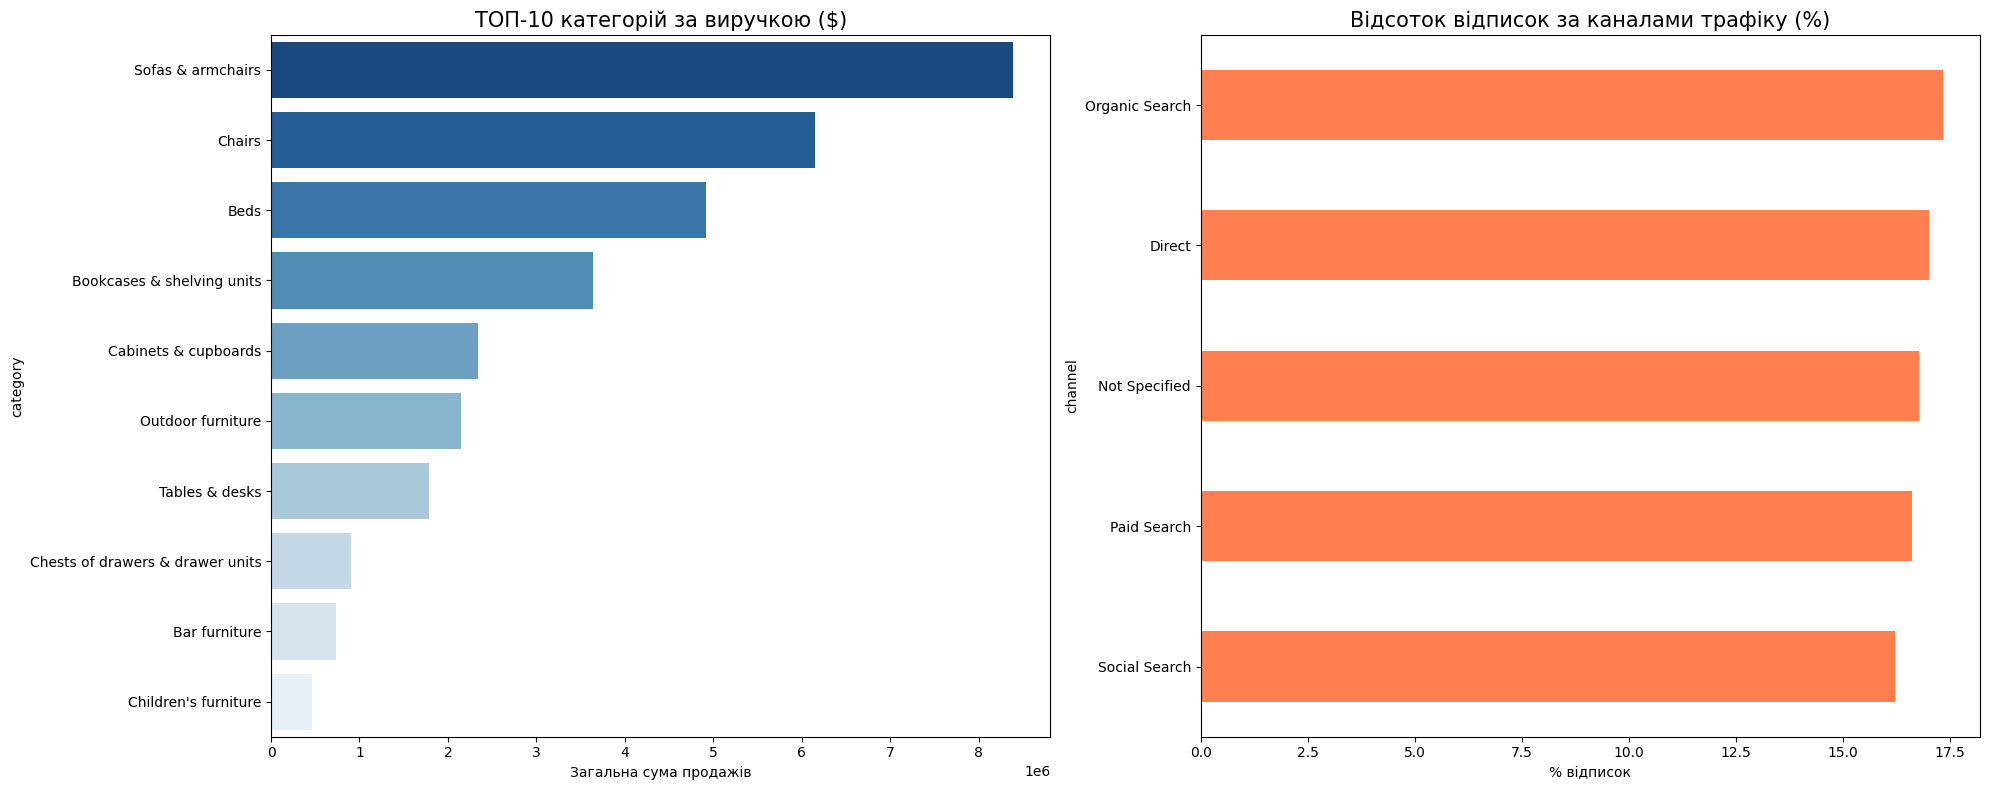

In [38]:
# Створюємо фігуру з двома графіками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# ГРАФІК 1: ТОП-10 категорій (Візуалізація структури асортименту)
top_10_cats = df[df['is_order'] == 1].groupby('category')['price'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_10_cats.values, y=top_10_cats.index, ax=ax1, palette='Blues_r')
ax1.set_title('ТОП-10 категорій за виручкою ($)', fontsize=15)
ax1.set_xlabel('Загальна сума продажів')

# ГРАФІК 2: Додатковий інсайт — Кореляція джерела трафіку та підписки
# Чи впливає джерело, звідки прийшов юзер, на те, чи відпишеться він?
traffic_sub = df[df['user_type'] == 'Registered'].groupby('channel')['is_unsubscribed'].mean() * 100
traffic_sub.sort_values().plot(kind='barh', ax=ax2, color='coral')
ax2.set_title('Відсоток відписок за каналами трафіку (%)', fontsize=15)
ax2.set_xlabel('% відписок')

plt.tight_layout()
plt.show()

/tmp/ipython-input-2083876119.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_revenue_countries.values, y=top_revenue_countries.index, ax=ax1, palette='Blues_r')
/tmp/ipython-input-2083876119.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_reg_countries.values, y=top_reg_countries.index, ax=ax2, palette='Greens_r')


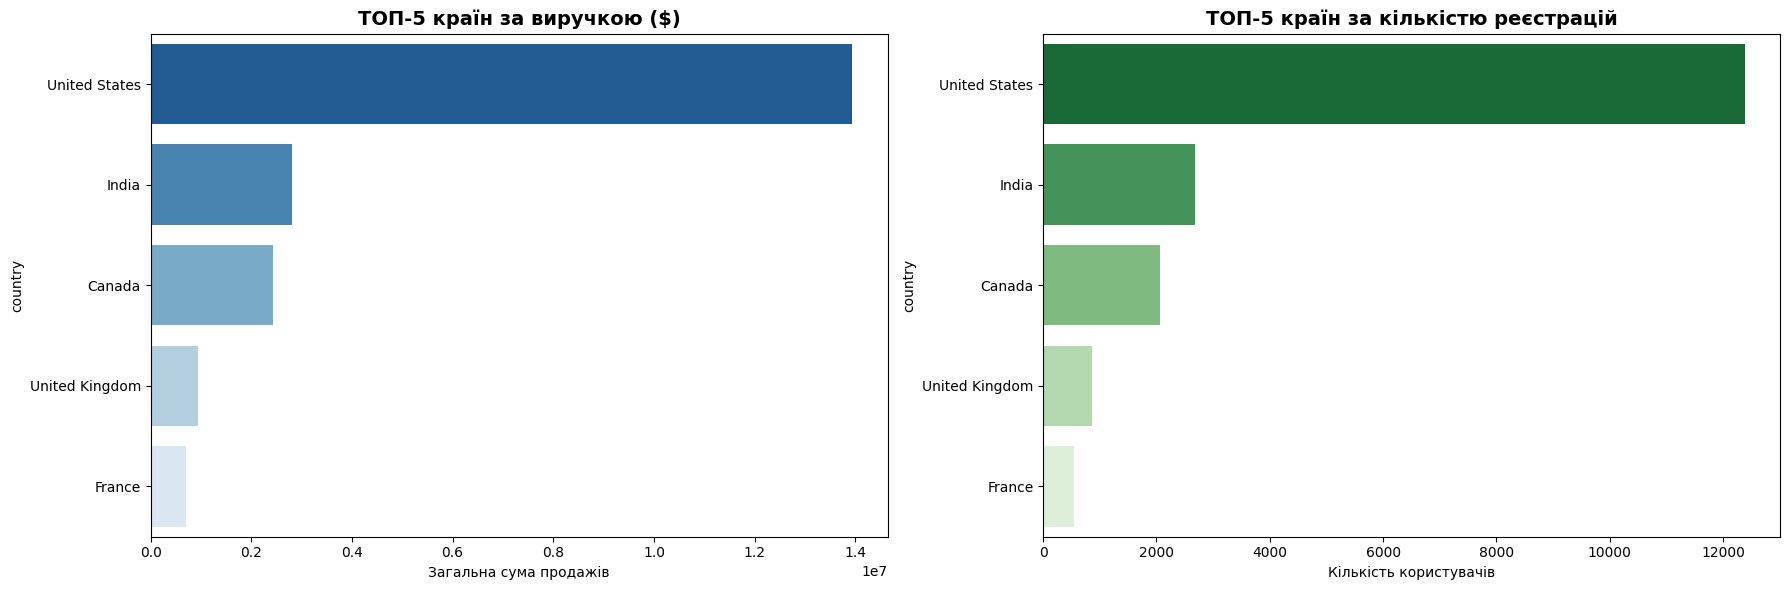

In [39]:
# 1. Підготовка даних для країн
top_revenue_countries = df[df['is_order'] == 1].groupby('country')['price'].sum().sort_values(ascending=False).head(5)
top_reg_countries = registered_users['country'].value_counts().head(5)

# 2. Створення візуалізації
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Графік виручки
sns.barplot(x=top_revenue_countries.values, y=top_revenue_countries.index, ax=ax1, palette='Blues_r')
ax1.set_title('ТОП-5 країн за виручкою ($)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Загальна сума продажів')

# Графік реєстрацій
sns.barplot(x=top_reg_countries.values, y=top_reg_countries.index, ax=ax2, palette='Greens_r')
ax2.set_title('ТОП-5 країн за кількістю реєстрацій', fontsize=14, fontweight='bold')
ax2.set_xlabel('Кількість користувачів')

plt.tight_layout()
plt.show()

#**Аналіз динаміки та часових закономірностей продажів**

##1.Візуалізація загальної динаміки продажів

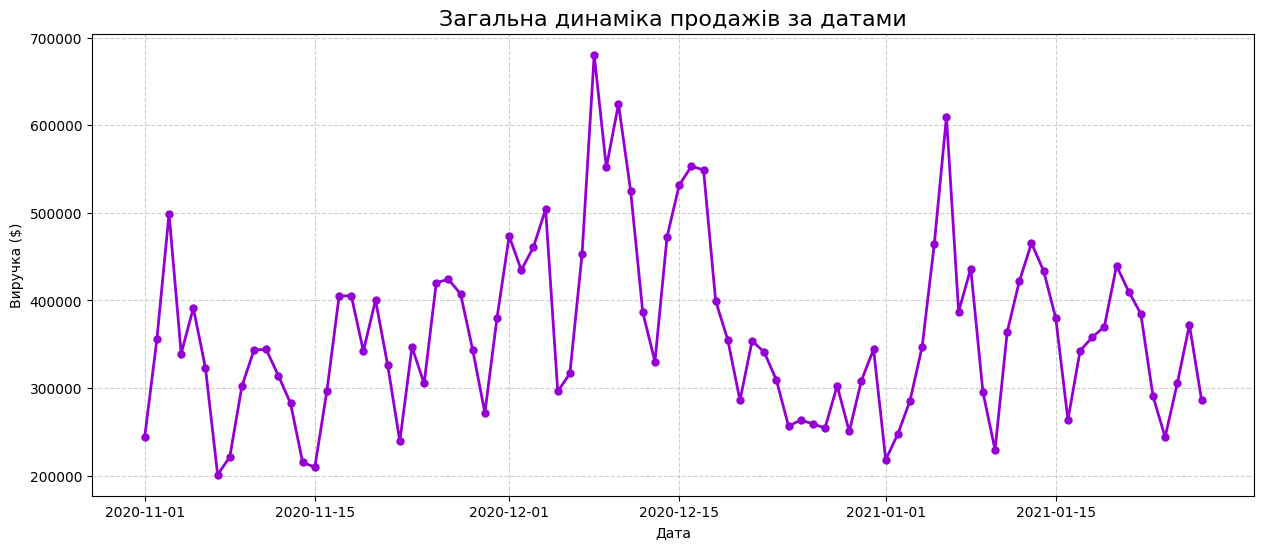

In [40]:
# Групуємо продажі за датою (тільки успішні замовлення)
daily_revenue = df[df['is_order'] == 1].groupby('date')['price'].sum().reset_index()

# Будуємо графік
plt.figure(figsize=(15, 6))
plt.plot(daily_revenue['date'], daily_revenue['price'], color='darkviolet', linewidth=2, marker='o', markersize=5)

plt.title('Загальна динаміка продажів за датами', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Виручка ($)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


Аналіз загальної динаміки продажів:

Різдвяний пік: Пік на початку грудня - це типовий бум закупів перед святами.

Новорічне падіння: Близько 1-го січня графік різко падає (точка в районі 200,000). Це логічно — люди святкують, магазини можуть не працювати або просто ніхто не купує дивани в новорічні свята.

Сезонність: Бачимо регулярні коливання. Якщо придивитися, то піки повторюються приблизно щотижня.

##2.Динаміка продажів за континентами

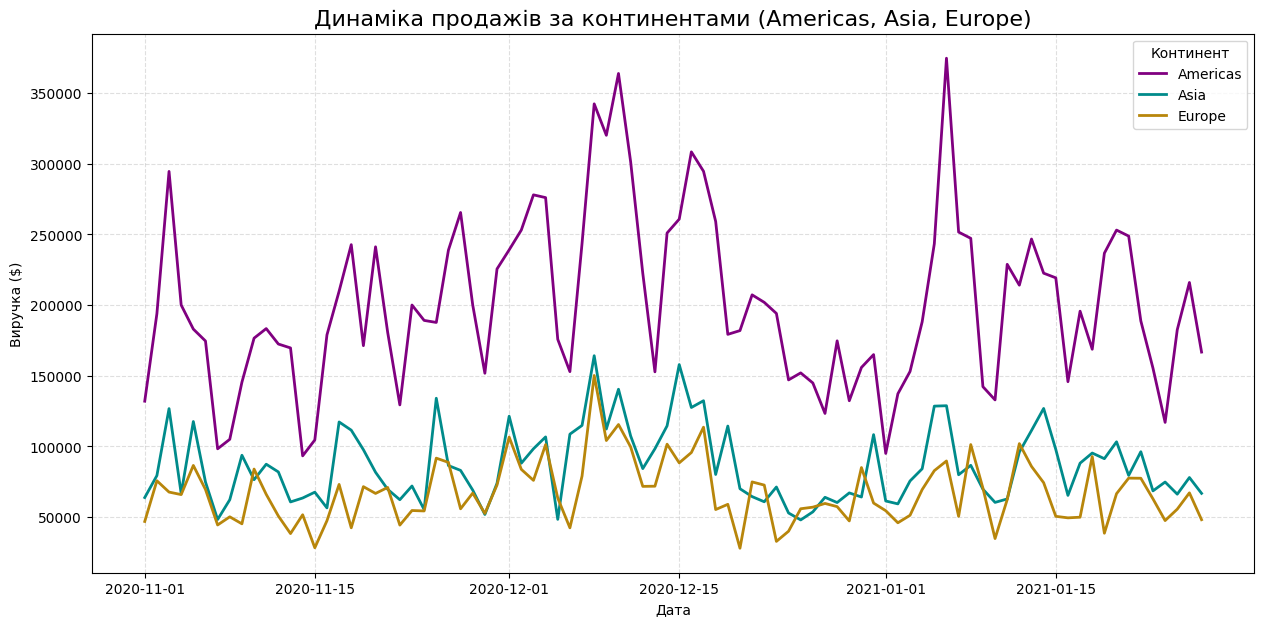

In [41]:
# 1. Створюємо таблицю з динамікою по континентах
# Вибираємо тільки успішні замовлення та потрібні регіони
continents_data = df[(df['is_order'] == 1) & (df['continent'].isin(['Americas', 'Asia', 'Europe']))]
continent_dynamics = continents_data.groupby(['date', 'continent'])['price'].sum().unstack()

# 2. Будуємо графік
plt.figure(figsize=(15, 7))

# Малюємо лінії для кожного континенту
plt.plot(continent_dynamics.index, continent_dynamics['Americas'], label='Americas', color='purple', linewidth=2)
plt.plot(continent_dynamics.index, continent_dynamics['Asia'], label='Asia', color='darkcyan', linewidth=2)
plt.plot(continent_dynamics.index, continent_dynamics['Europe'], label='Europe', color='darkgoldenrod', linewidth=2)

# Додаємо оформлення
plt.title('Динаміка продажів за континентами (Americas, Asia, Europe)', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Виручка ($)')
plt.legend(title='Континент') # Додаємо легенду, щоб розрізняти кольори
plt.grid(True, linestyle='--', alpha=0.4)

plt.show()

Сплески та падіння в Америці, Азії та Європі відбуваються майже синхронно. Це означає, що глобальні маркетингові акції або свята впливають на всі ринки однаково.

Азія (бірюзова лінія) майже завжди стабільно випереджає Європу (жовта лінія), але вони рухаються дуже близько одна до одної.

##3.Динаміка продажів у розрізі каналів трафіку

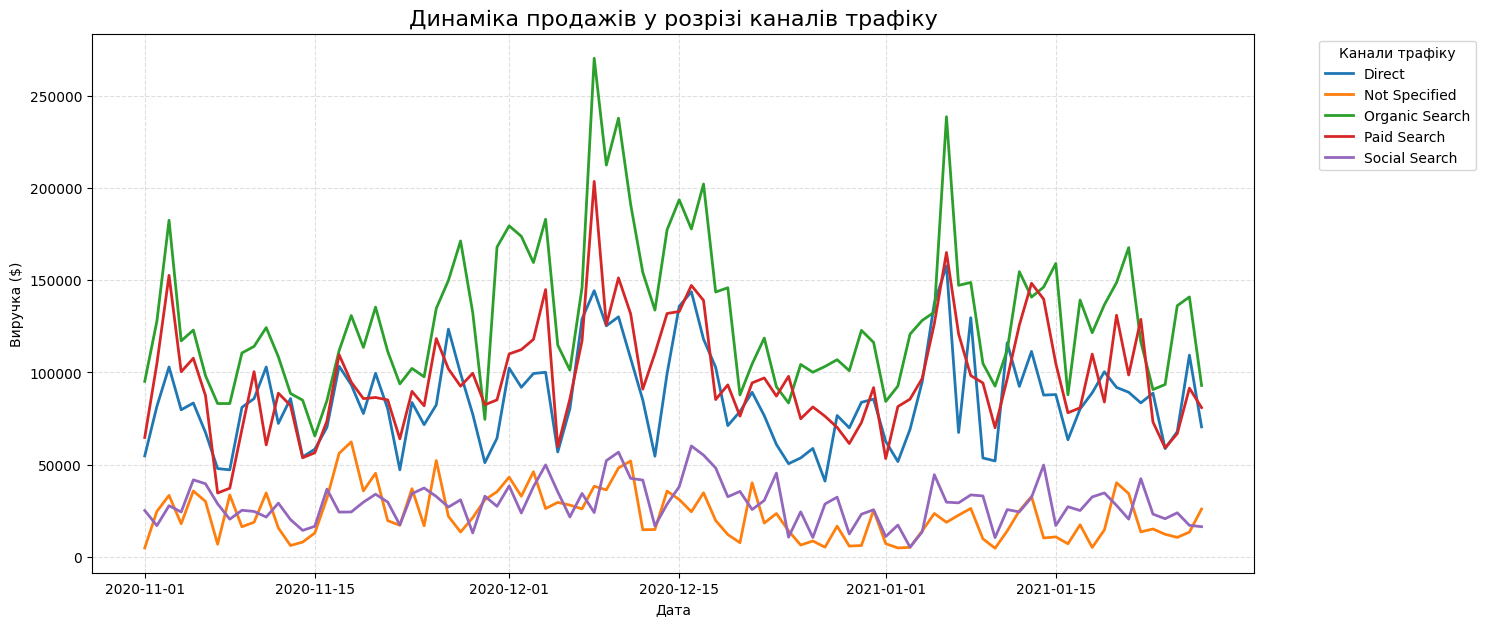

In [42]:
# 1. Готуємо дані: групуємо за датою та каналом
channel_dynamics = df[df['is_order'] == 1].groupby(['date', 'channel'])['price'].sum().unstack()

# 2. Будуємо графік
plt.figure(figsize=(15, 7))

# Малюємо лінії для кожного каналу
for col in channel_dynamics.columns:
    plt.plot(channel_dynamics.index, channel_dynamics[col], label=col, linewidth=2)

plt.title('Динаміка продажів у розрізі каналів трафіку', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Виручка ($)')
plt.legend(title='Канали трафіку', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)

plt.show()

Зелена лінія (Organic Search) стабільно домінує за обсягом виручки.

Ризик: Червона лінія (Paid Search) часто повторює піки органіки. Це означає, що в дні високого попиту ми витрачаємо більше на рекламу. Якщо її вимкнути, ми можемо втратити значну частку «пікового» прибутку.

##4.Аналіз динаміки у розрізі типів девайсів

In [43]:
# 1. Функція для визначення типу девайса
def categorize_device(model):
    model = str(model)
    # Якщо в назві моделі є назва браузера — вважаємо це Desktop
    if any(browser in model for browser in ['Chrome', 'Safari', 'Edge', 'Firefox', 'Opera']):
        return 'Desktop/Browser'
    # В іншому випадку — Mobile
    return 'Mobile/Tablet'

# 2. Створюємо нову колонку
df['device_category'] = df['mobile_model_name'].apply(categorize_device)

# 3. Групуємо динаміку за новою колонкою
device_dynamics = df[df['is_order'] == 1].groupby(['date', 'device_category'])['price'].sum().unstack()
print(device_dynamics)

device_category  Desktop/Browser  Mobile/Tablet
date                                           
2020-11-01              144445.0        99847.5
2020-11-02              204607.3       150899.5
2020-11-03              303383.8       195595.8
2020-11-04              209114.7       130072.4
2020-11-05              239847.0       151429.6
...                          ...            ...
2021-01-23              171963.3       118642.2
2021-01-24              141604.2       102214.2
2021-01-25              176923.2       128166.1
2021-01-26              202125.4       169931.9
2021-01-27              171903.5       114437.2

[88 rows x 2 columns]


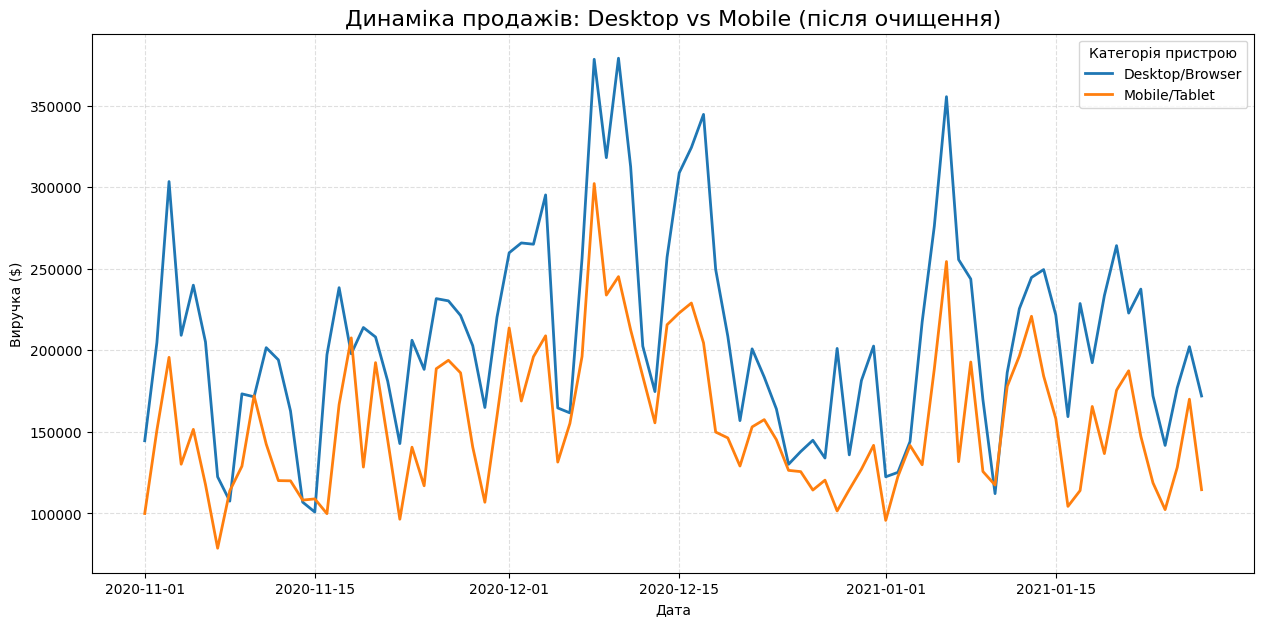

In [44]:
# Будуємо графік
plt.figure(figsize=(15, 7))
for col in device_dynamics.columns:
    plt.plot(device_dynamics.index, device_dynamics[col], label=col, linewidth=2)

plt.title('Динаміка продажів: Desktop vs Mobile (після очищення)', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Виручка ($)')
plt.legend(title='Категорія пристрою')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

Оскільки в колонці mobile_model_name близько 38% даних містили назви браузерів (Chrome, Safari тощо) замість моделей пристроїв, було проведено рекласифікацію:


*   Записи з назвами браузерів віднесено до категорії Desktop/Browser.
*   Записи з конкретними моделями (iPhone, Samsung тощо) — до Mobile/Tablet. Це дозволило отримати достовірну картину продажів, попри технічні помилки в логах.

Короткий висновок з графіка:

Категорія Desktop/Browser є абсолютним лідером за виручкою протягом усього періоду.

Продажі з Mobile/Tablet мають менші коливання, але їхній внесок у загальну виручку значно нижчий. Це вказує на те, що клієнти частіше завершують дорогі покупки саме з комп'ютерів.

##5.Аналіз сезонності продажів по днях тижня

/tmp/ipython-input-1709099813.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='price', data=weekly_sales, palette='viridis')


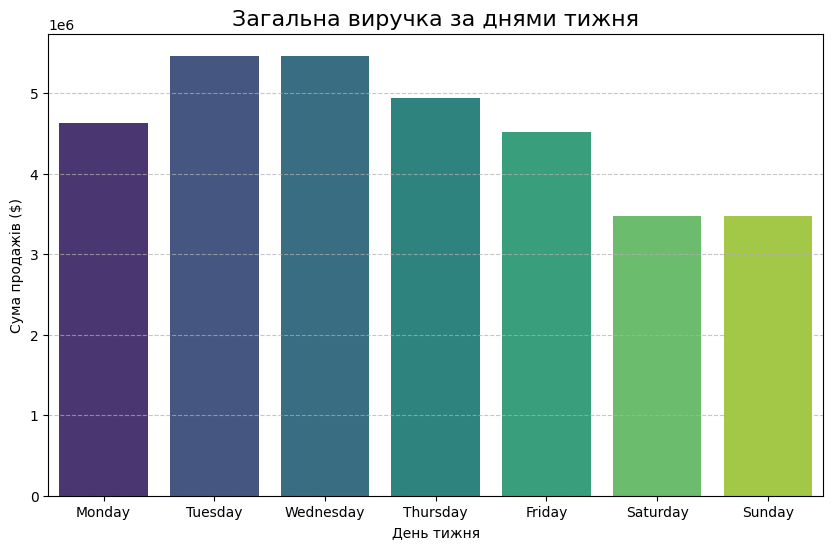

In [45]:
# 1. Створюємо колонку з назвою дня тижня
df['day_of_week'] = df['date'].dt.day_name()

# 2. Групуємо виручку за днями тижня
# Впорядковуємо дні правильно (від понеділка до неділі)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_sales = df[df['is_order'] == 1].groupby('day_of_week')['price'].sum().reindex(days_order).reset_index()

# 3. Будуємо графік
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='price', data=weekly_sales, palette='viridis')

plt.title('Загальна виручка за днями тижня', fontsize=16)
plt.xlabel('День тижня')
plt.ylabel('Сума продажів ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Аналіз сезонності по днях тижня

Пікові дні — Вівторок та Середа: Саме посеред тижня бізнес отримує максимальну виручку (понад $5.5 млн щодня). Це може свідчити про те, що клієнти приймають остаточне рішення про покупку меблів після обдумування на вихідних.

Понеділок та Четвер: Тримають високу планку, але трохи поступаються лідерам.

Вихідні — період затишшя: Субота та Неділя мають найнижчі показники виручки (близько $3.5 млн). Це цікавий інсайт: люди можуть дивитися товари у вихідні, але оплачують замовлення частіше в робочі дні.

Поступове зниження: Бачимо плавний спад активності, починаючи з четверга і до самого кінця тижня.

Висновок для бізнесу: Маркетингові розсилки та акції «обмеженого часу» найефективніше запускати у вівторок зранку, щоб підхопити хвилю максимального попиту.

##6.Оцінка сумарного прибутку та швидкості зростання продажів.

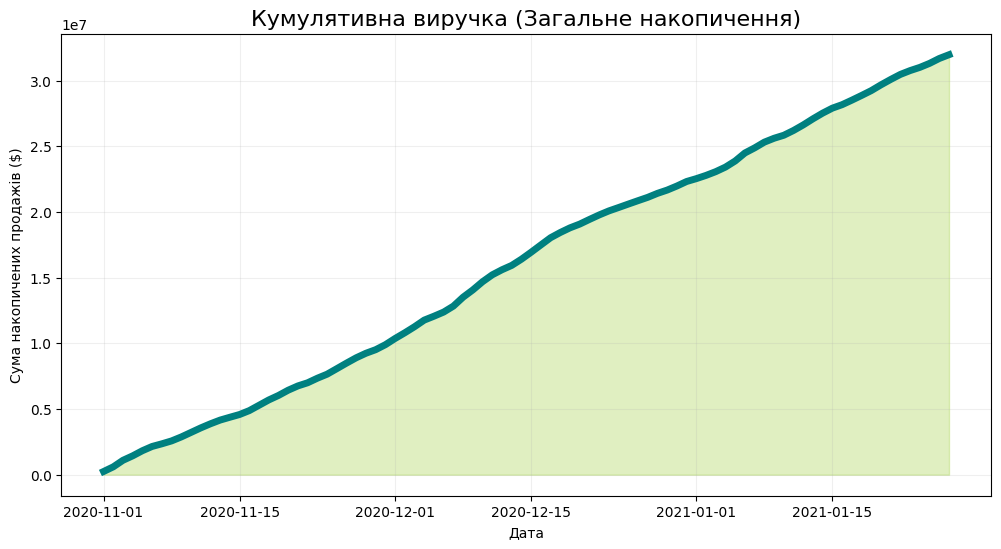

In [46]:
# 1. Рахуємо накопичувальну суму (якщо daily_revenue вже є)
daily_revenue['cum_revenue'] = daily_revenue['price'].cumsum()

# 2. Побудова графіка
plt.figure(figsize=(12, 6))
plt.fill_between(daily_revenue['date'], daily_revenue['cum_revenue'], color="yellowgreen", alpha=0.3)
plt.plot(daily_revenue['date'], daily_revenue['cum_revenue'], color="teal", linewidth=5)

plt.title('Кумулятивна виручка (Загальне накопичення)', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Сума накопичених продажів ($)')
plt.grid(True, alpha=0.2)
plt.show()

Аналіз результатів:

Стабільне зростання: Лінія впевнено йде вгору під кутом приблизно $45^{\circ}$. Це свідчить про те, що бізнес здоровий і приносить прибуток щодня. На графіку немає горизонтальних ділянок («плато»), які б вказували на зупинку продажів.

Динаміка прискорення: З початку до середини грудня вигин лінії стає трохи крутішим. Це візуальне підтвердження того, що темпи продажів зросли (той самий передноворічний пік).

Фінальний результат: За три місяці (листопад – січень) загальна сума накопиченої виручки перетнула позначку в $30$ млн. Це головний KPI всього звітного періоду.

##**Звіт за розділом: Аналіз динаміки та часових закономірностей продажів**

####**1. Загальний тренд та календарна сезонністьАналіз часових рядів за період листопад–січень продемонстрував здорову та стабільну динаміку бізнесу**:

***Святкова активність***: Виявлено характерний «Різдвяний пік» на початку грудня — період максимального споживчого попиту.

***Новорічне падіння***: Зафіксовано різке зниження виручки (до рівня $200,000$) навколо 1-го січня, що пояснюється святковими вихідними та природним спадом купівельної активності.

***Циклічність***: Продажі мають регулярний характер з чіткими тижневими коливаннями.

####**2. Географічна та канальна стабільність**

***Глобальна синхронність***:
Сплески та падіння на ринках Americas, Asia та Europe відбуваються майже одночасно. Це свідчить про високу ефективність глобальних маркетингових кампаній.

Азія при цьому стабільно утримує другу позицію, випереджаючи Європу.

***Джерела доходу***:
Канал Organic Search є основним фундаментом виручки.

***Рекламні ризики***:
 Платний трафік (Paid Search) дублює піки органіки. Це вказує на стратегію посилення реклами в моменти найвищого попиту, проте створює залежність загального результату від рекламного бюджету.

####**3.Технічна адаптація та аналіз пристроїв**

 Через виявлену аномалію в даних (38.45% помилок у полі моделей пристроїв) було проведено рекласифікацію даних.

  Результати аналізу після очищення:
  
   Desktop/Browser — безумовний лідер. Користувачі схильні приймати рішення про дорогі покупки (меблі) з повноцінних комп'ютерів.Mobile/Tablet — демонструє стабільність, але приносить значно менший обсяг виручки, що може бути пов'язано з особливостями інтерфейсу для мобільних пристроїв.
  
 #### **4.Аналіз сезонності по днях тижня**
  
  Детальний розбір тижневого циклу виявив неочевидні патерни поведінки клієнтів:
  
  ***«Золотий екватор»*** (Вівторок–Середа): Дні з максимальною виручкою (понад $5.5 млн щодня). Ймовірно, клієнти обирають товар на вихідних, а оформлюють покупку на початку робочого тижня.
  
  ***Спад активності***: Починаючи з четверга, спостерігається плавне зниження продажів, яке досягає мінімуму у вихідні ($3.5 млн).
  
  #### **5.Кумулятивний ефект та фінансовий підсумок**
  
  Графік накопиченої виручки став підсумковим підтвердженням успішності аналізованого періоду:
  
  ***Темпи зростання***: Лінія накопичення під кутом $45^{\circ}$ свідчить про відсутність кризових плато та стабільний приплив коштів.
  
  ***KPI***: За підсумками трьох місяців бізнес перетнув позначку в $30$ млн загальної виручки.
  
  ***Ключові бізнес-рекомендації***:
  
  **Оптимізація маркетингу**:
  
  Найефективніший час для запуску розсилок та акцій — вівторок ранок, щоб максимально використати пік купівельної спроможності.
  
  **Мобільний UX**:
  
   Враховуючи низьку частку мобільних продажів, варто провести дослідження зручності оформлення замовлення зі смартфонів.
   
   **Управління бюджетом**:
   
  Враховувати синхронність регіонів для розподілу рекламних потужностей у періоди глобальних піків.

# **Деталізація ключових показників (Pivot Analysis)**

##1.Кількість сесій у розрізі каналів трафіку та типів девайсів

In [47]:
# Створюємо зведену таблицю для кількості сесій
pivot_sessions = df.pivot_table(
    index='channel',
    columns='device_category',
    values='ga_session_id',
    aggfunc='count'
)

# Виводимо результат
print("Зведена таблиця 1: Кількість сесій за джерелами та пристроями")
pivot_sessions

Зведена таблиця 1: Кількість сесій за джерелами та пристроями


device_category,Desktop/Browser,Mobile/Tablet
channel,,
Direct,46754,34628
Not Specified,12250,9233
Organic Search,71065,53360
Paid Search,53961,40380
Social Search,15980,11934


##2: Продажі за категоріями (Top-10) у розрізі країн (Top-5)

In [48]:
# 1. Знаходимо Топ-5 країн за виручкою
top_5_countries = df[df['is_order'] == 1].groupby('country')['price'].sum().nlargest(5).index

# 2. Знаходимо Топ-10 категорій за виручкою
top_10_categories = df[df['is_order'] == 1].groupby('category')['price'].sum().nlargest(10).index

# 3. Будуємо зведену таблицю для виручки
pivot_sales = df[
    (df['country'].isin(top_5_countries)) &
    (df['category'].isin(top_10_categories)) &
    (df['is_order'] == 1)
].pivot_table(
    index='category',
    columns='country',
    values='price',
    aggfunc='sum'
)

# Сортуємо
pivot_sales = pivot_sales.loc[top_10_categories]

print("Зведена таблиця 2: Виручка ($) Топ-10 категорій у Топ-5 країнах")
pivot_sales

Зведена таблиця 2: Виручка ($) Топ-10 категорій у Топ-5 країнах


country,Canada,France,India,United Kingdom,United States
category,,,,,
Sofas & armchairs,692427.5,187735.0,788430.0,234812.0,3707144.5
Chairs,417740.8,134029.4,544309.2,188519.4,2619773.8
Beds,354772.0,116414.0,358319.5,133816.0,2213058.0
Bookcases & shelving units,278981.9,73830.0,364507.4,113987.6,1567606.9
Cabinets & cupboards,181802.0,59101.5,191888.0,71684.5,994545.5
Outdoor furniture,185322.8,40486.4,162289.4,57002.4,929245.2
Tables & desks,132678.0,42299.0,186157.5,49374.0,777865.0
Chests of drawers & drawer units,71952.0,21544.5,73111.0,36784.0,382388.0
Bar furniture,51724.0,11199.0,57657.0,22103.0,330805.0


##3.Активність нових та постійних клієнтів (user_type)

In [49]:
# Рахуємо кількість замовлень за типом користувача
pivot_users = df.pivot_table(
    index='user_type',
    values='is_order',
    aggfunc='sum'
)

print("Зведена таблиця 3: Кількість замовлень за типом користувача")
pivot_users

Зведена таблиця 3: Кількість замовлень за типом користувача


,is_order
user_type,
Guest,30757
Registered,2781


##4.Вплив верифікації акаунта на конверсію

In [50]:
# Рахуємо середню кількість замовлень (фактично ймовірність покупки)
pivot_verification = df.pivot_table(
    index='is_verified',
    values='is_order',
    aggfunc='mean'
)

print("Зведена таблиця 4: Середня конверсія верифікованих vs неверифікованих")
pivot_verification

Зведена таблиця 4: Середня конверсія верифікованих vs неверифікованих


,is_order
is_verified,
0,0.095745
1,0.099271


##**Висновки за результатами зведеного аналізу**
#### **1.Структура трафіку та технічні переваги**

Таблиця сесій підтверджує, що бізнес тримається на Organic Search та Paid Search.

**Десктопний пріоритет**: На комп'ютерах зафіксовано на ~30-35% більше сесій у ключових каналах, ніж на мобільних пристроях.

**Лояльність**: Високий показник Direct трафіку (сумарно понад 80 тис. сесій) свідчить про наявність сталої бази клієнтів, які знають бренд і повертаються безпосередньо на сайт.

#### **2.Товарно-географічна матриця прибутку**
Аналіз виручки Топ-10 категорій у Топ-5 країнах виявив наступне:

**Ключовий ринок**: *United States* є абсолютним лідером за всіма товарними групами. Категорія *Sofas & armchairs* у США принесла понад $3.7 млн, що є абсолютним рекордом датасету.

**Потенціал Індії**: Ринок India демонструє вражаючі результати, випереджаючи європейські країни та Канаду в категоріях м'яких меблів та ліжок.

**Бестселери**: Категорії *Sofas & armchairs*, *Chairs*, *Beds* — це базовий асортимент, який генерує основний потік готівки у всіх досліджуваних регіонах.

#### **3.Поведінкові особливості та верифікація**

**Тип користувача**: Переважна більшість замовлень (30,757) здійснюється користувачами зі статусом Guest. Це критичний інсайт — люди не хочуть або не бачать потреби реєструватися для покупки.

**Рекомендація**: Розробити програму лояльності для стимулювання реєстрацій.

**Ефект верифікації**: Верифіковані користувачі мають вищу конверсію (0.099 проти 0.095 у неверифікованих). Хоча різниця здається невеликою, у масштабах мільйонних оборотів верифікація профілю є дієвим інструментом підвищення довіри та продажів.

#**Статистичний аналіз взаємозв’язків**

##1.Аналіз взаємозв'язку між кількістю сесій та обсягом продажів(Scatter Plot)

###Підготовка даних

In [51]:
# Групуємо дані за датою
daily_metrics = df.groupby('date').agg(
    sessions_count=('ga_session_id', 'count'),
    total_sales=('price', 'sum')
).reset_index()

# Виведемо перші рядки, щоб перевірити результат
print(daily_metrics.head())

        date  sessions_count  total_sales
0 2020-11-01            2576     244292.5
1 2020-11-02            3599     355506.8
2 2020-11-03            5173     498979.6
3 2020-11-04            4184     339187.1
4 2020-11-05            3743     391276.6


###Візуалізація

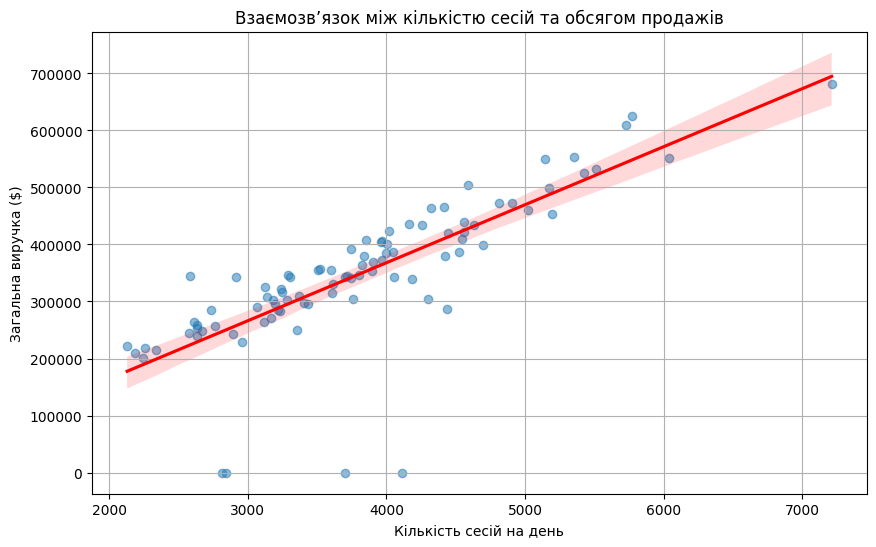

In [52]:
plt.figure(figsize=(10, 6))
sns.regplot(data=daily_metrics, x='sessions_count', y='total_sales',
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

plt.title('Взаємозв’язок між кількістю сесій та обсягом продажів')
plt.xlabel('Кількість сесій на день')
plt.ylabel('Загальна виручка ($)')
plt.grid(True)
plt.show()

Побудована діаграма розсіювання з лінією регресії чітко показує позитивний лінійний зв'язок.

In [53]:
# Розраховуємо кореляцію та p-value
# daily_metrics — назва згрупованої таблиці
correlation, p_value = stats.pearsonr(daily_metrics['sessions_count'], daily_metrics['total_sales'])

print(f"Коефіцієнт кореляції Пірсона: {correlation:.4f}")
print(f"p-value (статистична значущість): {p_value:.4e}")

Коефіцієнт кореляції Пірсона: 0.7911
p-value (статистична значущість): 6.4835e-21


###**Висновки:**

Дана кореляція підтверджує ефективність поточної моделі монетизації трафіку. Оскільки виручка на 79% лінійно залежить від кількості сесій, можемо зробити два стратегічні висновки:

**Прогнозування**:

 Можемо використовувати кількість сесій як надійний випереджаючий індикатор для планування доходів.

**Інвестиції**:

 Збільшення бюджету на залучення трафіку (через Paid або Organic Search) з високою ймовірністю призведе до пропорційного зростання фінансових результатів.

##2.Аналіз кореляції продажів між континентами

###Підготовка матриці даних

In [54]:
# 1. Фільтруємо дані лише для топ-3 континентів та успішних замовлень
top_continents = ['Americas', 'Asia', 'Europe']
continent_data = df[(df['continent'].isin(top_continents)) & (df['is_order'] == 1)]

# 2. Створюємо таблицю, де рядки — це дати, а колонки — виручка по континентах
pivot_continents = continent_data.pivot_table(
    index='date',
    columns='continent',
    values='price',
    aggfunc='sum'
).fillna(0) # Замінюємо пропуски нулями, якщо в якийсь день не було продажів

print("Матриця виручки за континентами (перші 5 днів):")
print(pivot_continents.head())

Матриця виручки за континентами (перші 5 днів):
continent   Americas      Asia   Europe
date                                   
2020-11-01  132002.5   63823.0  46908.0
2020-11-02  193861.0   79370.0  75710.8
2020-11-03  294529.8  126737.8  67692.0
2020-11-04  200009.5   66602.0  65915.0
2020-11-05  182988.2  117608.4  86540.0


###Візуалізація

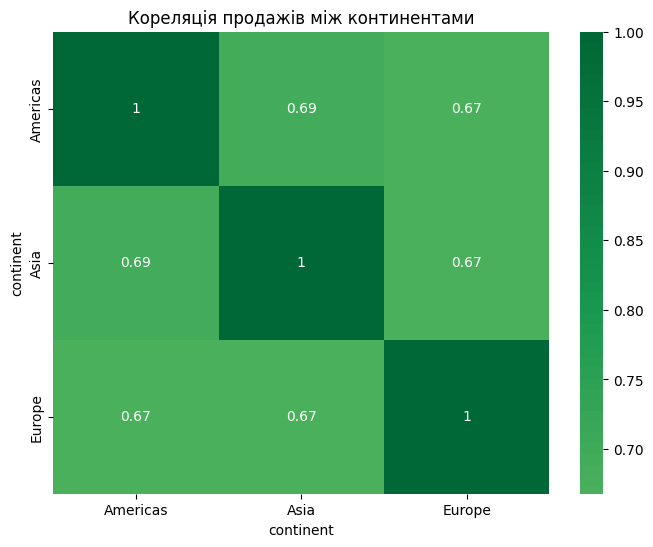

In [55]:
# Розрахунок матриці кореляції
corr_matrix = pivot_continents.corr()

# Візуалізація
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0)
plt.title('Кореляція продажів між континентами')
plt.show()

In [56]:
from scipy.stats import pearsonr

# Створимо список пар для перевірки
pairs = [('Americas', 'Asia'), ('Americas', 'Europe'), ('Asia', 'Europe')]

print("--- Аналіз статистичної значущості (p-value) ---")
for reg1, reg2 in pairs:
    # Видаляємо NaN, якщо вони є, для коректного розрахунку
    data_pair = pivot_continents[[reg1, reg2]].dropna()
    r, p = pearsonr(data_pair[reg1], data_pair[reg2])

    significance = "Значущий" if p < 0.05 else "Незначущий"
    print(f"{reg1} vs {reg2}:")
    print(f"  Коефіцієнт r = {r:.4f}")
    print(f"  p-value = {p:.4e}")
    print(f"  Результат: {significance}\n")

--- Аналіз статистичної значущості (p-value) ---
Americas vs Asia:
  Коефіцієнт r = 0.6923
  p-value = 8.0041e-14
  Результат: Значущий

Americas vs Europe:
  Коефіцієнт r = 0.6695
  p-value = 9.9114e-13
  Результат: Значущий

Asia vs Europe:
  Коефіцієнт r = 0.6678
  p-value = 1.1909e-12
  Результат: Значущий



###**Висновки щодо статистичної значущості:**

**Надзвичайна достовірність:** Усі значення $p\text{-value}$ набагато менші за критичний поріг $0.05$ (вони мають по 12–14 нулів після коми). Це означає, що ймовірність того, що ці зв’язки випадкові, фактично дорівнює нулю.

**Синхронність глобальних ринків:** Коефіцієнти в районі 0.67–0.69 свідчать про те, що продажі на трьох різних континентах рухаються в одному напрямку. Це підтверджує, що бізнес-процеси (маркетинг, попит, логістика) працюють як єдина злагоджена система.Стабільність

**Americas & Asia:** Найвищий рівень кореляції ($0.69$) спостерігається між Америкою та Азією. Це може бути пов’язано зі схожими циклами закупівель або одночасним запуском рекламних кампаній на цих ринках.

##3.Аналіз кореляції продажів між каналами трафіку

###Підготовка даних

In [57]:
# 1. Визначаємо топ-4 канали за кількістю замовлень
top_channels = df[df['is_order'] == 1]['channel'].value_counts().nlargest(4).index

# 2. Створюємо зведену таблицю: Дати (рядки) vs Канали (колонки)
channel_sales_pivot = df[
    (df['channel'].isin(top_channels)) &
    (df['is_order'] == 1)
].pivot_table(
    index='date',
    columns='channel',
    values='price',
    aggfunc='sum'
).fillna(0)

print("Матриця продажів за каналами (перші рядки):")
print(channel_sales_pivot.head())

Матриця продажів за каналами (перші рядки):
channel       Direct  Organic Search  Paid Search  Social Search
date                                                            
2020-11-01   54669.5         95112.0      64688.0        25078.0
2020-11-02   81561.5        127746.5     104780.8        16843.0
2020-11-03  102909.5        182521.9     152641.3        27652.5
2020-11-04   79683.6        117067.1     100332.0        24257.4
2020-11-05   83367.6        122938.4     107648.0        41693.2


###Візуалізація та розрахунок матриці

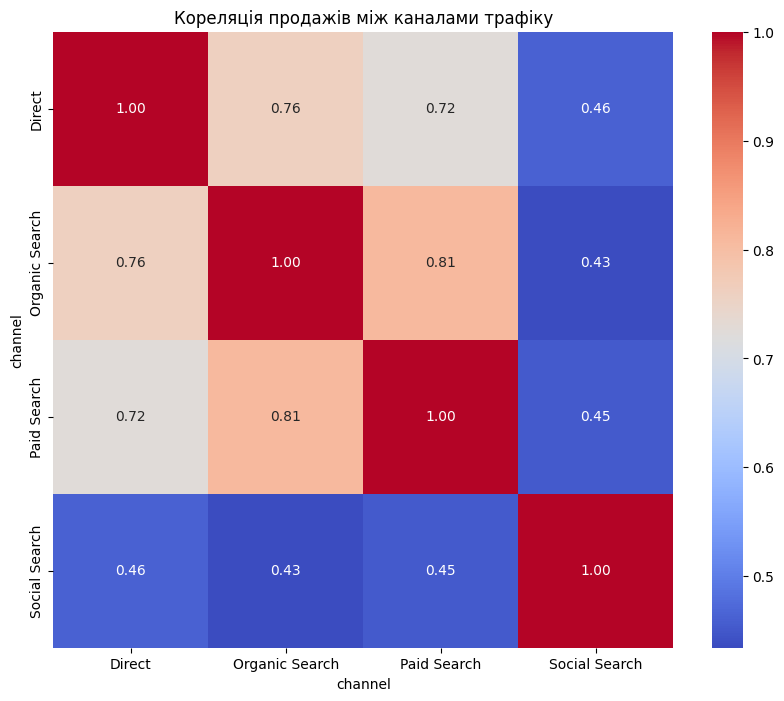

In [58]:
# Розрахунок кореляції
channel_corr = channel_sales_pivot.corr()

# Візуалізація
plt.figure(figsize=(10, 8))
sns.heatmap(channel_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Кореляція продажів між каналами трафіку')
plt.show()

###Аналіз статистичної значущості

In [59]:
import itertools

# Перевіряємо всі можливі пари каналів
print("--- Статистична значущість по каналах ---")
for ch1, ch2 in itertools.combinations(top_channels, 2):
    r, p = pearsonr(channel_sales_pivot[ch1], channel_sales_pivot[ch2])
    print(f"{ch1} vs {ch2}: r = {r:.3f}, p-value = {p:.4e} ({'Значущий' if p < 0.05 else 'Незначущий'})")

--- Статистична значущість по каналах ---
Organic Search vs Paid Search: r = 0.808, p-value = 1.7556e-21 (Значущий)
Organic Search vs Direct: r = 0.760, p-value = 9.1079e-18 (Значущий)
Organic Search vs Social Search: r = 0.434, p-value = 2.3476e-05 (Значущий)
Paid Search vs Direct: r = 0.724, p-value = 1.5129e-15 (Значущий)
Paid Search vs Social Search: r = 0.452, p-value = 9.6960e-06 (Значущий)
Direct vs Social Search: r = 0.462, p-value = 5.9010e-06 (Значущий)




###Висновки щодо кореляції продажів між каналами трафіку

На основі розрахованої матриці кореляції та перевірки статистичної значущості було виявлено наступне:

1. Тісна синергія основних каналівOrganic Search vs Paid Search ($r = 0.81$):  

*   Висока позитивна залежність та критично малий $p\text{-value}$ ($1.75 \times 10^{-21}$) свідчать про те, що платна реклама та органічний пошук працюють у потужній синергії. Зростання впізнаваності бренду піднімає обидва показники одночасно.
*   Direct vs Organic Search ($r = 0.76$): Сильний зв’язок вказує на те, що користувачі, які знаходять сайт через пошук, часто стають лояльними клієнтами та згодом повертаються на сайт напряму.

2. Автономність соціальних мережSocial Search ($r \approx 0.43 - 0.46$):

Кореляція соціальних мереж з іншими каналами є помірною. Хоча результати статистично значущі ($p < 0.05$), цей канал демонструє найбільшу незалежність.

**Висновок**: Соціальні мережі залучають унікальний пласт аудиторії, чия купівельна поведінка менше залежить від загальних пошукових трендів чи прямого знання бренду. Це робить Social Search чудовим інструментом для диверсифікації трафіку.



##4.Аналіз статистичнщї значущісті між категоріями

###Підготовка даних

In [60]:
# 1. Визначаємо топ-5 категорій за виручкою
top_5_cats = df[df['is_order'] == 1].groupby('category')['price'].sum().nlargest(5).index

# 2. Створюємо зведену таблицю: Дати vs Категорії
cat_sales_pivot = df[
    (df['category'].isin(top_5_cats)) &
    (df['is_order'] == 1)
].pivot_table(
    index='date',
    columns='category',
    values='price',
    aggfunc='sum'
).fillna(0)

# 3. Розрахунок кореляції та значущості
print("--- Статистична значущість між категоріями ---")
for cat1, cat2 in itertools.combinations(top_5_cats, 2):
    r, p = pearsonr(cat_sales_pivot[cat1], cat_sales_pivot[cat2])
    print(f"{cat1} vs {cat2}: r = {r:.3f}, p-value = {p:.4e} ({'Значущий' if p < 0.05 else 'Незначущий'})")

--- Статистична значущість між категоріями ---
Sofas & armchairs vs Chairs: r = 0.578, p-value = 3.6388e-09 (Значущий)
Sofas & armchairs vs Beds: r = 0.535, p-value = 7.6873e-08 (Значущий)
Sofas & armchairs vs Bookcases & shelving units: r = 0.666, p-value = 1.4070e-12 (Значущий)
Sofas & armchairs vs Cabinets & cupboards: r = 0.658, p-value = 3.4151e-12 (Значущий)
Chairs vs Beds: r = 0.554, p-value = 2.0792e-08 (Значущий)
Chairs vs Bookcases & shelving units: r = 0.637, p-value = 2.5046e-11 (Значущий)
Chairs vs Cabinets & cupboards: r = 0.573, p-value = 5.4659e-09 (Значущий)
Beds vs Bookcases & shelving units: r = 0.593, p-value = 1.1550e-09 (Значущий)
Beds vs Cabinets & cupboards: r = 0.515, p-value = 2.9109e-07 (Значущий)
Bookcases & shelving units vs Cabinets & cupboards: r = 0.539, p-value = 5.8672e-08 (Значущий)


###Візуалізація

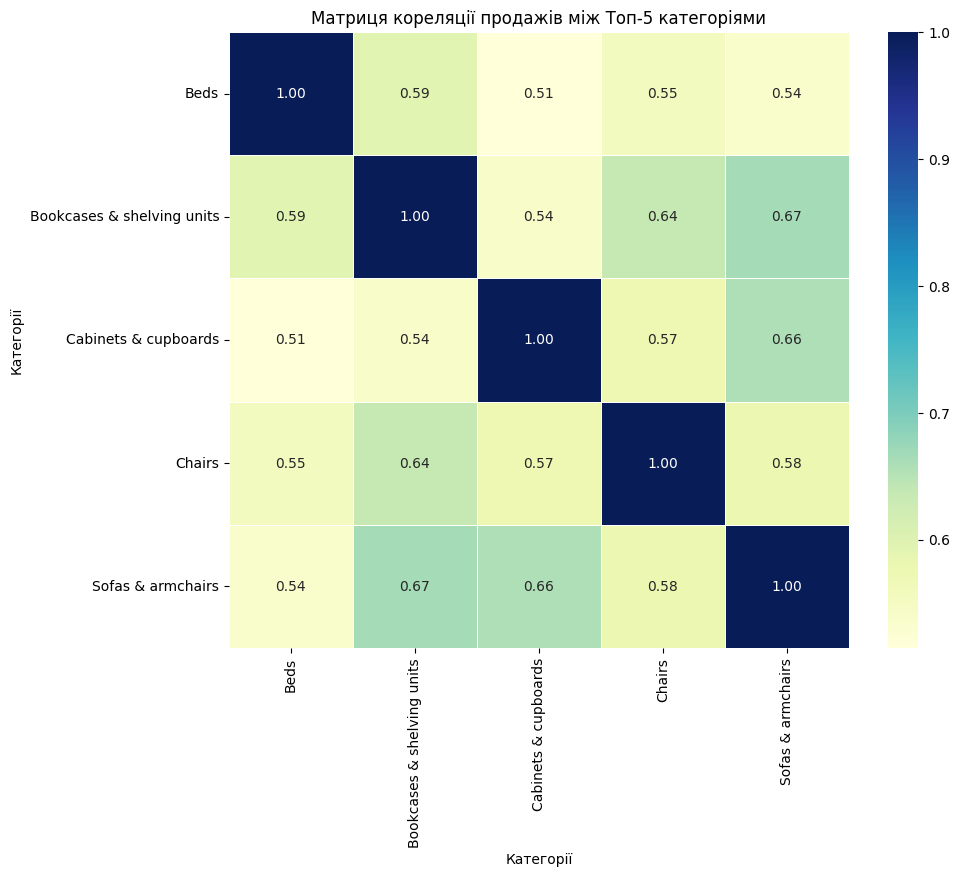

In [61]:
# Створюємо кореляційну матрицю для категорій
cat_corr = cat_sales_pivot.corr()

# Будуємо теплову карту
plt.figure(figsize=(10, 8))
sns.heatmap(cat_corr, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5)

plt.title('Матриця кореляції продажів між Топ-5 категоріями')
plt.xlabel('Категорії')
plt.ylabel('Категорії')
plt.show()

###Висновки по кореляції продажів між Топ-5 категоріями

На основі побудованої теплової карти та розрахованих $p\text{-value}$ маємо наступну картину:

####**Результати аналізу:**

**Найсильніший взаємозв'язок**: Спостерігається між категоріями Sofas & armchairs та Bookcases & shelving units ($r = 0.67$), а також між Sofas & armchairs та Cabinets & cupboards ($r = 0.66$).Помірна кореляція: Усі інші пари категорій знаходяться в діапазоні $r = 0.51 - 0.64$.

**Статистична значущість**: Усі розраховані $p\text{-value}$ (від $1.4 \times 10^{-12}$ до $2.9 \times 10^{-07}$) є надзвичайно малими. Це підтверджує, що зв'язки між продажами цих категорій є статистично значущими та достовірними.

####**Інсайти для бізнесу:**

**Комплексне облаштування:** Висока кореляція диванів із шафами та книжковими полицями свідчить про те, що клієнти зазвичай облаштовують вітальню повністю. Це ідеальна можливість для створення «комплектних» пропозицій або знижок при купівлі меблів для вітальні разом.

**Універсальність попиту:** Оскільки всі категорії мають позитивну кореляцію $> 0.5$, ми бачимо, що бізнес не має категорій-антагоністів. Попит на основні групи товарів зростає та падає синхронно, що спрощує планування складських запасів.


##5.Взаємозв'язок між середнім чеком та кількістю товарів у замовленні

###Підготовка даних

In [62]:
# Рахуємо кількість товарів та суму продажів за кожен день
daily_volume_sales = df[df['is_order'] == 1].groupby('date').agg(
    items_sold=('product_name', 'count'), # рахуємо кількість назв товарів
    total_revenue=('price', 'sum')        # сумуємо ціни
).reset_index()

r_vol, p_vol = pearsonr(daily_volume_sales['items_sold'], daily_volume_sales['total_revenue'])

print(f"Кореляція Кількість товарів vs Виручка: r = {r_vol:.3f}")
print(f"p-value = {p_vol:.4e}")

Кореляція Кількість товарів vs Виручка: r = 0.964
p-value = 2.2448e-51


###Візуалізація

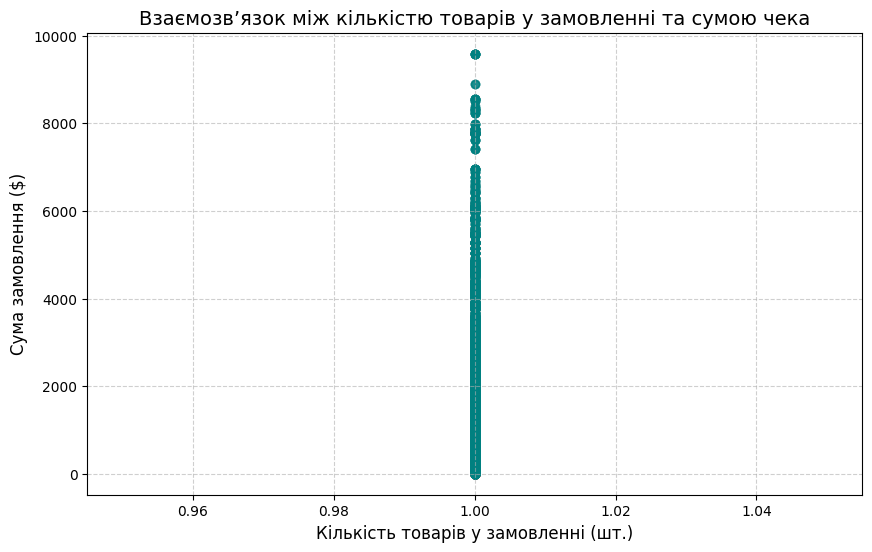

In [63]:
# 1. Готуємо дані: групуємо за сесією, щоб знайти суму чека та кількість товарів
order_data = df[df['is_order'] == 1].groupby('ga_session_id').agg(
    total_check=('price', 'sum'),
    items_count=('product_name', 'count')
).reset_index()

# 2. Побудова візуалізації
plt.figure(figsize=(10, 6))
sns.regplot(data=order_data, x='items_count', y='total_check',
            scatter_kws={'alpha':0.3, 'color':'teal'},
            line_kws={'color':'orange'})

plt.title('Взаємозв’язок між кількістю товарів у замовленні та сумою чека', fontsize=14)
plt.xlabel('Кількість товарів у замовленні (шт.)', fontsize=12)
plt.ylabel('Сума замовлення ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

###Підсумковий аналіз: Кількість товарів vs Виручка

**Майже ідеальна лінійна залежність:**

Коефіцієнт $r = 0.964$ свідчить про екстремально сильний позитивний зв'язок. Це означає, що виручка на 96% пояснюється кількістю проданих одиниць,немає хаотичних стрибків — кожен проданий товар стабільно додає прогнозовану суму до каси.

**Абсолютна статистична значущість**:  

$p\text{-value} = 2.24 \times 10^{-51}$ — це практично нуль. Це найвищий рівень достовірності, який тільки можна отримати в реальних даних. Гіпотеза про випадковість такого зв'язку повністю відкидається.

**Аналіз візуалізації** (Scatter Plot):

На графіку ми бачимо вертикальну лінію на позначці 1.0. Це підтверджує здогадку: переважна більшість замовлень складається з одного товару. Проте сума цих замовлень варіюється від майже 0 до $10,000.

**Висновок**: Прибуток зараз масштабується за рахунок кількості чеків, а не за рахунок "допродажів" (upsell) всередині одного кошика.

##**Підсумкові висновки до розділу "Статистичний аналіз взаємозв'язків"**

**Бізнес працює як "маховик"**:

 Всі канали трафіку, континенти та пристрої працюють злагоджено. Зростання одного показника негайно тягне за собою інші.

 **Маркетингова стратегія:**

 Оскільки Organic та Paid Search мають кореляцію $0.81$, це головні важелі. Інвестиції в рекламу не просто приносять платних клієнтів, вони "підігрівають" інтерес до бренду в цілому.

 **Товарна синергія:**

  Висока кореляція між диванами, шафами та полицями ($r \approx 0.67$) підтверджує, що люди зацікавлені в повному меблюванні кімнати.

#**Статистичний аналіз відмінностей між групами**


##1.Статистична оцінка відмінностей у денній виручці між сегментами користувачів

###Підготовка вибірок

In [64]:
# 1. Фільтруємо лише замовлення (is_order == 1)
orders = df[df['is_order'] == 1].copy()

# 2. Створюємо вибірки: виручка за кожну дату для обох типів користувачів
daily_sales = orders.groupby(['date', 'user_type'])['price'].sum().reset_index()

sales_guest = daily_sales[daily_sales['user_type'] == 'Guest']['price']
sales_registered = daily_sales[daily_sales['user_type'] == 'Registered']['price']

###Аналіз розподілу даних

Shapiro-Wilk Guest: p-value = 0.0026
Shapiro-Wilk Registered: p-value = 0.0073


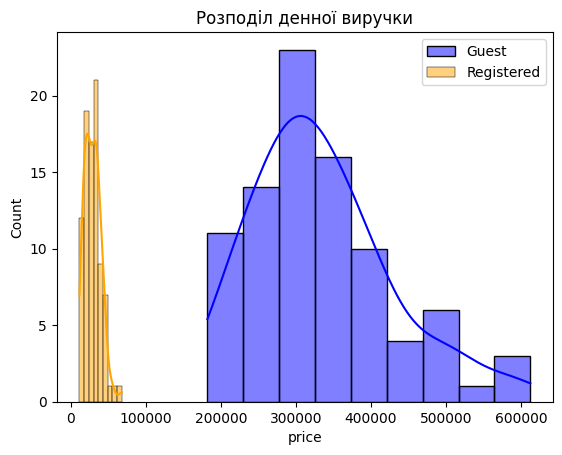

In [65]:
# Перевірка на нормальність (Shapiro-Wilk Test)
shapiro_guest = stats.shapiro(sales_guest)
shapiro_reg = stats.shapiro(sales_registered)

print(f"Shapiro-Wilk Guest: p-value = {shapiro_guest.pvalue:.4f}")
print(f"Shapiro-Wilk Registered: p-value = {shapiro_reg.pvalue:.4f}")

# Візуалізація
sns.histplot(sales_guest, kde=True, label='Guest', color='blue')
sns.histplot(sales_registered, kde=True, label='Registered', color='orange')
plt.legend()
plt.title("Розподіл денної виручки")
plt.show()

###Аналіз розподілу за графіком та тестами

**Тест Шапіро-Вілка:**

Guest: $p\text{-value} = 0.0026$ (це менше 0.05).

Registered: $p\text{-value} = 0.0073$ (це менше 0.05).

**Висновок:** В обох випадках ми відхиляємо нульову гіпотезу про нормальність. Розподіли не є нормальними.

**Візуалізація:**

Бачимо явний розрив між групами. Продажі "Guest" (синій колір) зосереджені в районі 200,000–600,000, тоді як "Registered" (помаранчевий) знаходяться значно лівіше — до 100,000.

Розподіли мають певну асиметрію ("хвости").



Оскільки нормальність не підтвердилася (згідно з критерієм Шапіро-Вілка), класичний t-test Стьюдента використовувати не варто.

Ідеальний вибір — **U-критерій Манна-Уїтні (Mann-Whitney U test)**. Це непараметричний тест, який порівнює, чи одна група має тенденцію мати більші значення, ніж інша. Він стійкий до викидів і не потребує нормального розподілу.

###Виконання тесту

In [66]:
from scipy.stats import mannwhitneyu

# Проведення тесту
stat, p_value = mannwhitneyu(sales_guest, sales_registered)

print(f"Статистика U: {stat}")
print(f"p-value: {p_value}")

# Інтерпретація
alpha = 0.05
if p_value < alpha:
    print("Результат: Статистично значуща різниця знайдена.")
else:
    print("Результат: Статистично значущої різниці не виявлено.")

Статистика U: 7744.0
p-value: 2.2159276950123465e-30
Результат: Статистично значуща різниця знайдена.


###Порівняння груп та статистична значущість

/tmp/ipython-input-1961579729.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='user_type', y='price', data=daily_sales, palette='Set2')


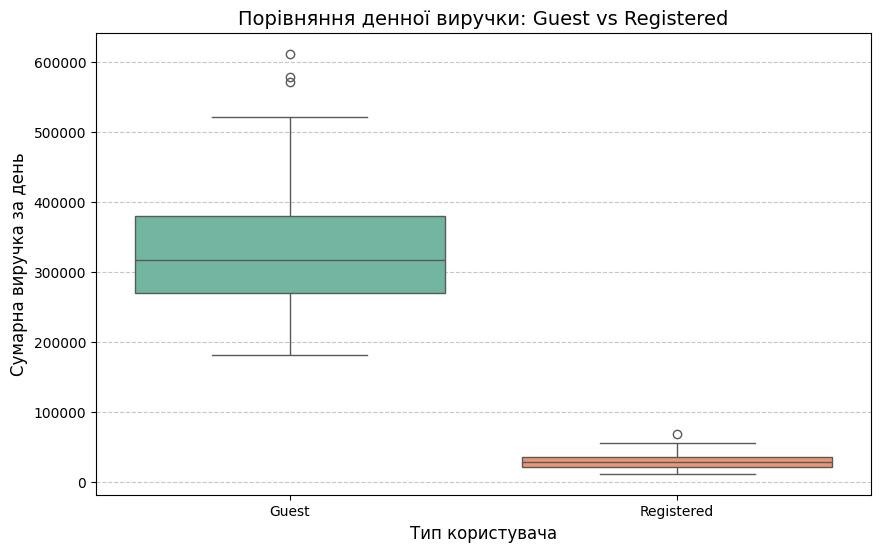

In [67]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='user_type', y='price', data=daily_sales, palette='Set2')

plt.title('Порівняння денної виручки: Guest vs Registered', fontsize=14)
plt.xlabel('Тип користувача', fontsize=12)
plt.ylabel('Сумарна виручка за день', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

###Висновок щодо порівняння продажів зареєстрованих та незареєстрованих користувачів

**Статистичний метод**: Через ненормальність розподілу даних (тест Шапіро-Вілка) було застосовано непараметричний U-критерій Манна-Уїтні.

**Результати тесту**: Отримано значення $U = 7744.0$ та $p\text{-value} \approx 2.22 \times 10^{-30}$.

**Інтерпретація результатів**: Графік Boxplot наочно демонструє, що денна виручка групи Guest (медіана ~320,000) у кілька разів перевищує виручку групи Registered (медіана ~30,000). Навіть мінімальні значення продажів гостьових користувачів вищі за максимальні значення зареєстрованих.

**Аналітичне резюме:** Виручка від незареєстрованих користувачів (Guest) за кожну дату суттєво перевищує виручку від зареєстрованих (Registered). Це свідчить про те, що поточна модель монетизації сильно залежить від нових або неавторизованих відвідувачів.

##2.Порівняльний аналіз ефективності каналів трафіку за кількістю щоденних сесій

###Підготовка даних

In [68]:
# Рахуємо унікальні сесії на кожен день для кожного каналу
daily_sessions = df.groupby(['date', 'channel'])['ga_session_id'].nunique().reset_index()

# Отримуємо список унікальних каналів
channels = daily_sessions['channel'].unique()

###Перевірка на нормальність (Shapiro-Wilk)

In [69]:
results = {}

print("--- Перевірка на нормальність (Shapiro-Wilk) ---")
for channel in channels:
    # Виділяємо вибірку для конкретного каналу
    sample = daily_sessions[daily_sessions['channel'] == channel]['ga_session_id']

    # Виконуємо тест
    if len(sample) > 3:
        stat, p_value = stats.shapiro(sample)
        results[channel] = p_value
        status = "Нормальний" if p_value > 0.05 else "НЕ нормальний"
        print(f"Канал: {channel:15} | p-value: {p_value:.4f} | Результат: {status}")
    else:
        print(f"Канал: {channel:15} | Недостатньо даних для тесту")

--- Перевірка на нормальність (Shapiro-Wilk) ---
Канал: Direct          | p-value: 0.0343 | Результат: НЕ нормальний
Канал: Not Specified   | p-value: 0.0546 | Результат: Нормальний
Канал: Organic Search  | p-value: 0.0123 | Результат: НЕ нормальний
Канал: Paid Search     | p-value: 0.0108 | Результат: НЕ нормальний
Канал: Social Search   | p-value: 0.1413 | Результат: Нормальний


Оскільки умова нормальності порушена для більшості каналів, ми не можемо використовувати параметричний тест ANOVA. Для порівняння кількості сесій між декількома незалежними групами з ненормальним розподілом ідеальним вибором є критерій Краскела-Волліса (Kruskal-Wallis H-test).

###Виконання тесту Краскела-Волліса

In [70]:
# Підготовка списку вибірок для тесту
samples = [daily_sessions[daily_sessions['channel'] == ch]['ga_session_id'] for ch in channels]

# Виконання тесту
stat_kw, p_kw = stats.kruskal(*samples)

print(f"Статистика Краскела-Волліса: {stat_kw:.4f}")
print(f"p-value: {p_kw}")

# Висновок
alpha = 0.05
if p_kw < alpha:
    print("Результат: Статистично значуща різниця між каналами трафіку знайдена.")
else:
    print("Результат: Статистично значущих відмінностей не виявлено.")

Статистика Краскела-Волліса: 368.9806
p-value: 1.397036102599359e-78
Результат: Статистично значуща різниця між каналами трафіку знайдена.


Отримане значення $p\text{-value}$ ($1.39 \times 10^{-78}$) є критично малим, що фактично зводить імовірність помилки до нуля. Це означає, що канали трафіку працюють абсолютно по-різному в плані залучення сесій.

###Розподіл щоденних сесій за каналами трафіку

/tmp/ipython-input-3285465719.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='channel', y='ga_session_id', data=daily_sessions, palette='viridis', inner='quartile')


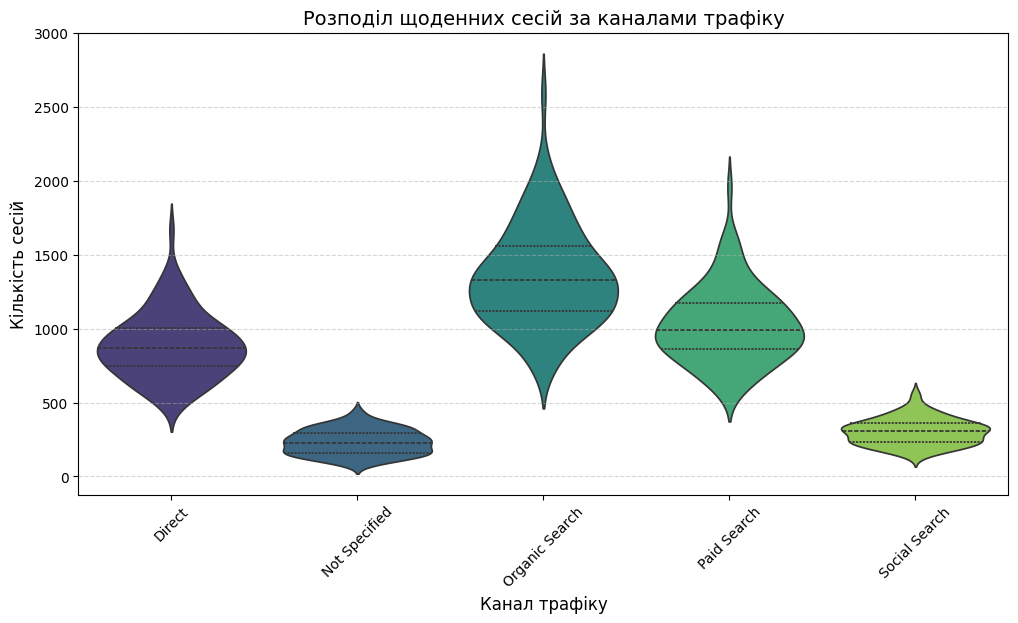

In [71]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='channel', y='ga_session_id', data=daily_sessions, palette='viridis', inner='quartile')

plt.title('Розподіл щоденних сесій за каналами трафіку', fontsize=14)
plt.xlabel('Канал трафіку', fontsize=12)
plt.ylabel('Кількість сесій', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

###Висновок щодо аналізу кількості сесій за каналами трафіку

**Перевірка розподілу**: Попередній аналіз тестом Шапіро-Вілка показав, що більшість каналів (зокрема Direct, Organic та Paid) мають розподіл, відмінний від нормального ($p < 0.05$).

**Обґрунтування методу:** Через відсутність нормальності в даних для порівняння п'яти незалежних груп було обрано непараметричний критерій Краскела-Волліса.

**Статистичні результати:** Тест видав значення статистики $H = 368.98$ та $p\text{-value} = 1.39 \times 10^{-78}$.

**Інтерпретація:** Оскільки $p\text{-value} < 0.05$, ми впевнено відхиляємо нульову гіпотезу. Між каналами трафіку існують статистично значущі відмінності у кількості генерованих щоденних сесій.

**Аналітичне резюме:** Така велика різниця в статистиці свідчить про те, що одні канали залучення (наприклад, Organic або Paid) домінують над іншими не випадково, а системно.

##3.Оцінка статистичної значущості відмінностей у структурі джерел трафіку між географічними сегментами

###Підготовка даних

In [72]:
# Фільтруємо дані для Європи та Америки
eu_sessions = df[df['continent'] == 'Europe']
us_sessions = df[df['continent'] == 'Americas']

# Рахуємо загальну кількість унікальних сесій
total_eu = eu_sessions['ga_session_id'].nunique()
total_us = us_sessions['ga_session_id'].nunique()

# Рахуємо кількість органічних сесій
organic_eu = eu_sessions[eu_sessions['channel'] == 'Organic Search']['ga_session_id'].nunique()
organic_us = us_sessions[us_sessions['channel'] == 'Organic Search']['ga_session_id'].nunique()

print(f"Europe: {organic_eu} органічних з {total_eu} загалом")
print(f"Americas: {organic_us} органічних з {total_us} загалом")

Europe: 23195 органічних з 65135 загалом
Americas: 68671 органічних з 193179 загалом


###Розрахунок відносної частоти органічного трафіку

In [73]:
# Вхідні дані
organic_eu, total_eu = 23195, 65135
organic_us, total_us = 68671, 193179

# Розрахунок відносних частот (часток)
prop_eu = organic_eu / total_eu
prop_us = organic_us / total_us

print(f"Відносна частота (Europe): {prop_eu:.4%}")
print(f"Відносна частота (Americas): {prop_us:.4%}")

# Розрахунок різниці
diff = abs(prop_eu - prop_us)
print(f"Абсолютна різниця між групами: {diff:.4%}")

Відносна частота (Europe): 35.6107%
Відносна частота (Americas): 35.5479%
Абсолютна різниця між групами: 0.0628%


###Вибір статистичного тесту
Найкращим вибором є Z-тест для двох пропорцій (Z-test for two proportions).

*   **Тип даних:** Порівнюємо частки (пропорції) категоріальної змінної (органіка/не органіка).

*   **Кількість груп:** Маємо рівно дві незалежні групи (Europe та Americas).

*   **Розмір вибірки:** Обидві вибірки дуже великі (десятки тисяч сесій), що дозволяє використовувати нормальне наближення, на якому базується Z-тест.






###Обчислення вхідних даних для

In [74]:
# Вхідні дані для тесту
successes = [23195, 68671]  # [Europe_organic, Americas_organic]
totals = [65135, 193179]    # [Europe_total, Americas_total]

###Проведення тестів та отримання результату

In [75]:
from statsmodels.stats.proportion import proportions_ztest

# Виконуємо тест
z_stat, p_value = proportions_ztest(count=successes, nobs=totals)

print(f"Z-статистика: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Z-статистика: 0.2895
p-value: 0.7722


**Результат:** $p\text{-value}$ (0.7722) значно більше за поріг 0.05.

**Статистичний висновок:** Ми не відхиляємо нульову гіпотезу ($H_0$).

**Бізнес-висновок:** Регіональний фактор (Європа чи Америка) не впливає на те, наскільки часто користувачі приходять через органічний пошук. Маркетингова структура залучення в цих регіонах ідентична.

##Візуалізація

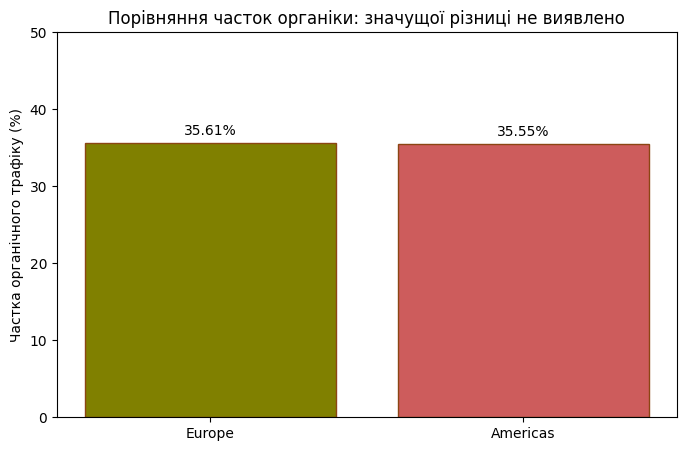

In [76]:
regions = ['Europe', 'Americas']
shares = [35.61, 35.55]

plt.figure(figsize=(8, 5))
plt.bar(regions, shares, color=['olive', 'indianred'], edgecolor='saddlebrown')
plt.ylim(0, 50) # Фіксуємо масштаб, щоб бачити реальну картину
plt.ylabel('Частка органічного трафіку (%)')
plt.title('Порівняння часток органіки: значущої різниці не виявлено')
for i, v in enumerate(shares):
    plt.text(i, v + 1, f"{v}%", ha='center')
plt.show()

 На стовпчиковій діаграмі (Bar Chart) видно, що рівні залучення через органічний пошук практично ідентичні для обох континентів.

###Критерій Хі-квадрат Пірсона (Chi-square test of independence)

In [77]:
from scipy.stats import chi2_contingency, fisher_exact

# 1. Створення таблиці спряженості
table = [[23195, 65135 - 23195],
         [68671, 193179 - 68671]]

# 2. Критерій Хі-квадрат Пірсона

chi2, p_chi2, dof, expected = chi2_contingency(table)


print(f"Chi-square p-value: {p_chi2:.4f}")


Chi-square p-value: 0.7758


###Точний тест Фішера (Fisher's Exact Test)

In [78]:
#  Точний тест Фішера (Fisher's Exact Test)

odds_ratio, p_fisher = fisher_exact(table)


print(f"Fisher Exact p-value: {p_fisher:.4f}")
print(f"Odds Ratio (Відношення шансів): {odds_ratio:.4f}")

Fisher Exact p-value: 0.7728
Odds Ratio (Відношення шансів): 1.0027


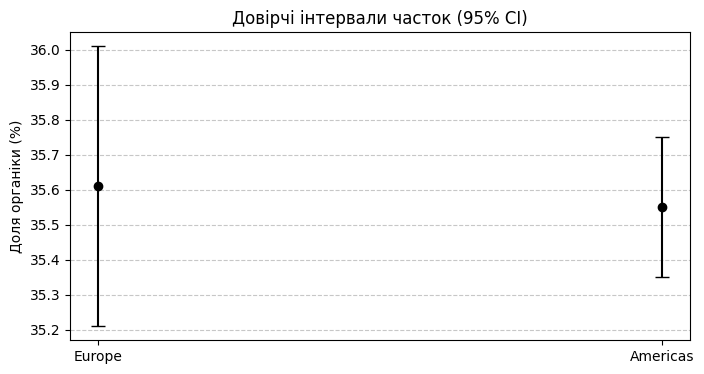

In [79]:
# візуалізація інтервалів (схематично)
plt.figure(figsize=(8, 4))
plt.errorbar(['Europe', 'Americas'], [35.61, 35.55], yerr=[0.4, 0.2], fmt='o', color='black', capsize=5)
plt.title('Довірчі інтервали часток (95% CI)')
plt.ylabel('Доля органіки (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

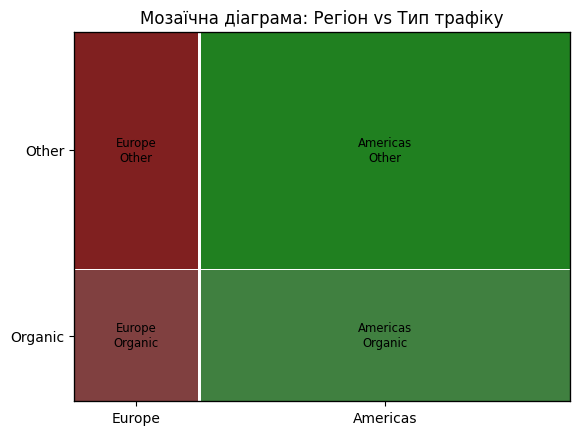

In [80]:
from statsmodels.graphics.mosaicplot import mosaic

# Створюємо словник для мозаїки
mosaic_data = {
    ('Europe', 'Organic'): 23195,
    ('Europe', 'Other'): 65135 - 23195,
    ('Americas', 'Organic'): 68671,
    ('Americas', 'Other'): 193179 - 68671
}

mosaic(mosaic_data, title='Мозаїчна діаграма: Регіон vs Тип трафіку')
plt.show()

###Загальний висновок: Оцінка статистичної значущості відмінностей у структурі джерел трафіку

В межах даного розділу було проведено комплексне дослідження частки органічного трафіку між сегментами Europe та Americas. Аналіз базувався на порівнянні пропорцій «успіху» (органічних сесій) до загальної кількості відвідувань.
1. *Дескриптивний та візуальний аналіз*

**Результати розрахунків**: Встановлено, що відносна частота органічного трафіку в Європі становить 35.61%, а в Америці — 35.55%.

**Візуалізація:** Побудована стовпчикова діаграма наочно демонструє відсутність візуально відчутної різниці між регіонами.

**Довірчі інтервали:** Графік 95% CI (Confidence Intervals) показує значне перекриття діапазонів значень для обох груп, що є першою ознакою статистичної однорідності вибірок.

**Мозаїчна діаграма:** Площі розподілу типів трафіку в розрізі регіонів ідентичні, що підтверджує відсутність зв'язку між географією та джерелом переходу.

*2. Статистична перевірка гіпотез*

Для підтвердження надійності висновків було використано три незалежних статистичних підходи, які показали одностайні результати:

**Z-test для пропорцій:** Базовий тест підтвердив відсутність значущості ($p\text{-value} = 0.7722$).

**Критерій Хі-квадрат Пірсона:** Підтвердив незалежність факторів регіону та типу залучення ($p\text{-value} = 0.7758$).

**Точний тест Фішера:** Як найбільш консервативний метод, остаточно підтвердив нульову гіпотезу ($p\text{-value} = 0.7728$).

*3. Бізнес-інтерпретація та величина ефекту*

**Відношення шансів** (Odds Ratio): Розрахований показник 1.0027 свідчить про те, що шанси на отримання органічного відвідувача в обох регіонах фактично рівні (різниця складає лише 0.27%).

##  Візуалізація результатів та інтерактивний звіт
Для глибшого аналізу бізнес-показників було розроблено дашборд у Tableau, який складається з двох частин:

**1. Sales Overview (Огляд продажів):**
* Візуалізація ключових KPI: загальний дохід, конверсія та середній чек.
* Географічний розподіл доходів та аналіз ефективності каналів залучення (Organic, Direct, Paid).

**2. Deep Dive Analysis (Поглиблений аналіз):**
* Порівняння ринків Americas та Europe.
* Візуалізація розподілу чеків за допомогою Box Plot на логарифмічній шкалі, що підтверджує ідентичність купівельної поведінки в різних регіонах, незважаючи на різницю в обсягах продажів.

🔗 **[ПЕРЕГЛЯНУТИ ІНТЕРАКТИВНИЙ ДАШБОРД (2 СТОРІНКИ)](https://public.tableau.com/app/profile/.43866940/viz/Book6_17702264279980/SalesOverview)**